In [2]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/home/monteirod/script/utils/')
import utils as u
import matplotlib as m

from scipy.stats import bootstrap
import statsmodels.api as sm
import xesmf as xe
import matplotlib.dates as mdates
import sys
from scipy import stats
import datetime
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import xarray as xr
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import regionmask
import pandas as pd
import geopandas
import warnings
from glob import glob
from uncertainties import unumpy
warnings.filterwarnings('ignore')

# Reference characteristics of the snow cover in the European Alps, section 3.1

In [193]:
## Defined variable
var = 'tas'
yr_start = 1985
yr_end = 2015

## Path 
data_path = '/cnrm/cen/users/NO_SAVE/monteirod/dataset_monthly/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/HISTALP_Alps/'
shp = geopandas.read_file(shp_path)
output_path = '/home/monteirod/tmp/Comparison_UE_Alps/'

## List of dataset names : keys = label names ; values = file extension names
ls_name = {
    'MTMSI': 'MTMSI',
    'MESCAN-SURFEX': 'UERRA',
    'CERRA-Land': "CERRA_Land",
    "ERA5": 'ERA5',
    'ERA5-Crocus': 'ERA5_CROCUS',
    'ERA5-Land': 'ERA5_Land',
    "CNRM-AROME": 'AROME',
    'CNRM-ALADIN': 'ALADIN'}

## List of spatial dimension names : keys = label names ; values = dimension names list
ls_spatial_dim = {
    'MTMSI': ['Number_of_points'],
    'MESCAN-SURFEX': ['x', 'y'],
    'CERRA-Land': ['x', 'y'],
    "ERA5": ['lat', 'lon'],
    'ERA5-Crocus': ['lat', 'lon'],
    'ERA5-Land': ['lat', 'lon'],
    "CNRM-AROME": ['x', 'y'],
    'CNRM-ALADIN': ['x', 'y']}


## List of color for each datasets
lightness = 0.9
ls_name_color = {'OBS': 'black',
                 'MODIS': 'darkgray',
                 'MTMSI': 'yellowgreen',
                 'MESCAN-SURFEX': 'chartreuse',
                 'CERRA-Land': 'darkgreen',
                 "ERA5": 'gold',
                 'ERA5-Crocus': 'darkorange',
                 'ERA5-Land': 'brown',
                 "CNRM-AROME": u.adjust_lightness('mediumblue',
                                                  lightness),
                 'CNRM-ALADIN': u.adjust_lightness('lightblue',
                                                   lightness)}

## Modification of list depending on the variables investigated
if var == 'snd':
    ls_name['OBS'] = "OBS_insitu_reference"
    ls_spatial_dim['OBS'] = ['Station_Name']
    var_name = 'Snow depth'
    unit = '(m)'

elif var == 'pr':
    ls_name['OBS'] = "LAPrec"
    ls_spatial_dim['OBS'] = ['x', 'y']
    var_name = 'Precipitation'
    unit = '(mm/day)'

elif var == 'tas':
    ls_name['OBS'] = "E_OBS"
    ls_spatial_dim['OBS'] = ['lon', 'lat']
    var_name = 'Temperature'
    unit = '(°C)'
    

## Load raw pre-treated datasets into a dict without any treatment

ds = {}

for i in range(0, len(list(ls_name.values()))):
    ds[list(ls_name.keys())[i]] = xr.open_dataset(data_path+var+'/'+var+'_' +
                                                  list(ls_name.values())[i]+'.nc').sel(time = slice(str(yr_start),str(yr_end)))
    
    # Mask all data outside the boundaries of the Alpine convention
    ds[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds[list(ls_name.keys())[i]],shp_path, 'lat', 'lon', shp['NAME']).drop(['abbrevs', 'names']).mean(dim = 'region')

## Time series

In [194]:
## Treat dataset

ls_alt = np.arange(-150,3300,300)
choosen_alt = [600,1500,2400]

ds_shaped = {}

for i in range(0,len(list(ls_name.values()))):
    ds_shaped[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]],ls_alt).sel(middle_slices_ZS = choosen_alt).mean(dim = ls_spatial_dim[list(ls_name.keys())[i]])

# Create the dataframe

df = []
for i in range(0,len(list(ls_name.values()))):
    df_i = ds_shaped[list(ls_name.keys())[i]][var].to_dataframe().reset_index().dropna()
    df.append(df_i)
df = pd.concat(df, keys = list(ls_name.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})


KeyboardInterrupt



In [ ]:
## Plot 

ls_markers = {'OBS':'o','MODIS':'','MTMSI':'','MESCAN-SURFEX':'','CERRA-Land':'',"ERA5":'','ERA5-Crocus':'','ERA5-Land':'', "CNRM-AROME":'','CNRM-ALADIN':''}
ls_size = {'OBS':10,'MODIS':1,'MTMSI':1,'MESCAN-SURFEX':1,'CERRA':1,"ERA5":1,'ERA5-Crocus':1,'ERA5-Land':1, "CNRM-AROME":1,'CNRM-ALADIN':1}
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")

g = sns.relplot(data=df, x="time", y=var, hue = 'Dataset', col_order = list(reversed(choosen_alt)),col = 'middle_slices_ZS',
                kind ='line', palette = ls_name_color, col_wrap=1,sizes = ls_size ,facet_kws={'sharey': False, 'sharex': True}, height=5, aspect=10/4, alpha = 0.7)

sns.move_legend(g, "upper left", bbox_to_anchor=(0.17, 1.1), ncol = 3, frameon = True)

# Specific marker and linewidth for observation plot
obs = df[df['Dataset']=='OBS']
for i in range(0,len(list(reversed(choosen_alt)))):
    sns.lineplot(data = obs[obs['middle_slices_ZS']==list(reversed(choosen_alt))[i]],x = 'time', y = var, legend = None, marker = 'o', linewidth = 0.7,alpha = 0.8, ax = g.axes[i] , color = 'k', markersize = 2.5)

# Labelled
g.set_titles("Elevation : {col_name} m")
g.set_ylabels(var_name+' '+unit)
g.set(xticks=np.unique(df.time)[0::12])
g.set(xlim=(ds['OBS'].time[0].values,ds['OBS'].time[-1].values))
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig(output_path+'Time_series_value_'+var+'.pdf', bbox_inches='tight')


## Table of scores

In [ ]:
## Treat dataset
ls_month = [11,12,1,2,3,4] # Selected months
ls_month_name = ['J','F','M','A','M','J','J','A','S','O','N','D']
period = ''.join(ls_month_name[i-1] for i in ls_month)
ls_alt = np.arange(-150,3300,300) # List of the boundaries for the elevation band
choosen_alt = [600,1500,2400] # List of the middle elevation band choosen

ds_shaped = {}

# Selection of months of interest only, elevation slicing, selection of elevation bands, and spatial mean for each elevation slices 
for i in range(0,len(list(ls_name.values()))):
        
    ds_shaped[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]].isel(time=ds[list(ls_name.keys())[i]].time.dt.month.isin(ls_month)),ls_alt).sel(middle_slices_ZS = choosen_alt)
    # Equal weight to each regional mean
    # ds_shaped[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds_shaped[list(ls_name.keys())[i]],shp_path, 'lat', 'lon', shp['NAME']).drop(['abbrevs', 'names']).mean(dim = list(ls_spatial_dim.values())[i]).mean(dim = 'region')
    # Equal weight to each grid points
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].mean(dim = list(ls_spatial_dim.values())[i])
    # Select only complete season if they are overlapping from one year to the next
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[0]))+'-'+str(ls_month[0]),str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[-1]))+'-'+str(ls_month[-1])))

# Define reference
reference = ds_shaped['OBS']

## Compute metrics based on the selected time series for each datasets
ls_metrics = ['MEAN','ME','MAE','CORRELATION']

for i in range(0,len(list(ls_name.values()))):

    # Mean values of each datasets
    ds_shaped[list(ls_name.keys())[i]]['MEAN'] = (ds_shaped[list(ls_name.keys())[i]][var]).mean(dim = 'time')
    # Mean errors (ME)
    ds_shaped[list(ls_name.keys())[i]]['ME'] = (ds_shaped[list(ls_name.keys())[i]][var] - reference[var]).mean(dim = 'time')
    # Mean absolute errors (MAE)
    ds_shaped[list(ls_name.keys())[i]]['MAE'] = (np.abs(ds_shaped[list(ls_name.keys())[i]][var] - reference[var])).mean(dim = 'time')
    # Correlation
    ds_shaped[list(ls_name.keys())[i]]['CORRELATION'] = xr.corr(ds_shaped[list(ls_name.keys())[i]][var],reference[var], dim = 'time')

    # Calculate in relative for precipitation and snow depth ME and MAE (+ compute MAPE)
    if var == 'pr' or var == 'snd':
        ds_shaped[list(ls_name.keys())[i]]['ME'] = ds_shaped[list(ls_name.keys())[i]]['ME']/reference[var].mean(dim = 'time')*100
        ds_shaped[list(ls_name.keys())[i]]['MAE'] = ds_shaped[list(ls_name.keys())[i]]['MAE']/reference[var].mean(dim = 'time')*100
        ds_shaped[list(ls_name.keys())[i]]['MAPE'] = ((np.abs(ds_shaped[list(ls_name.keys())[i]][var] - reference[var]))/reference[var]*100).mean(dim = 'time')
        
table = []
for i in range(0,len(list(ls_name.values()))):
    table_i = ds_shaped[list(ls_name.keys())[i]][ls_metrics] # Select solely error metrics
    table_i = table_i.to_dataframe().reset_index()[ls_metrics+['middle_slices_ZS']].dropna()
    table.append(table_i)
    
table = pd.concat(table, keys = list(ls_name.keys()))
table = table.reset_index().rename(columns = {'level_0':'Dataset'})[['Dataset','middle_slices_ZS']+ls_metrics]
table = table[table['Dataset'] != 'OBS'] # remove reference from the table
table = table.set_index(['middle_slices_ZS', 'Dataset']).sort_index(level ='middle_slices_ZS', ascending = False, sort_remaining=False) # index by descending elevation band, then Datasets

In [ ]:
## Heatmap

sns.set(font_scale = 1.1)

fig, ax = plt.subplots(figsize = (5,7))

for col in table:
    vmin = table[col].min()
    vmax = table[col].max()
    
    if 'CORRELATION' in col:
        cmap = 'OrRd'
        vmin, vmax = 0.7,1
        fmt = '.2f'
            
    elif 'MEAN' in col:
        if var == 'tas':
            cmap = 'coolwarm'
            vmin, vmax = -10,10
            fmt = '.1f'
        elif var == 'snd':
            cmap = 'Blues'
            vmin, vmax = 0,2
            fmt = '.2f'
        elif var == 'pr':
            cmap = 'GnBu'
            vmin, vmax = 0,6
            fmt = '.1f'
            
    elif 'ME' in col:
        if var == 'tas':
            cmap = 'coolwarm'
            vmin, vmax = -2,2
            fmt = '.1f'
        elif var == 'snd':
            cmap = 'coolwarm_r'
            vmin, vmax = -50,50
            fmt = '.0f'
        elif var == 'pr':
            cmap = 'coolwarm_r'
            vmin, vmax = -50,50 
            fmt = '.0f'

    elif 'MAE' in col:
        if var == 'tas':
            cmap = 'OrRd'
            vmin, vmax = 0,2
            fmt = '.1f'
        elif var == 'snd':
            cmap = 'OrRd'
            vmin, vmax = 0,100
            fmt = '.0f'
        elif var == 'pr':
            cmap = 'OrRd'
            vmin, vmax = 0,100
            fmt = '.0f'
            
    mask = table.copy()
    for col_m in mask:
        mask[col_m] = col != col_m

    sns.heatmap(data=table,
                annot=table.to_numpy(), annot_kws={'size': 'medium'}, fmt=fmt,
                mask=mask,
                cmap=cmap, vmin=vmin, vmax=vmax, cbar=False, ax=ax, alpha = 0.8)
    
    # Vertical and horizontal lines to delimitate metrics and elevation bands
    ls_line = np.arange(0,(len(ls_name.keys())-1)*(len(choosen_alt)+1),(len(ls_name.keys())-1))
    xline = -1.75
    ax.hlines(ls_line,*ax.get_xlim(), color ='k', lw = 2)
    ax.vlines(np.arange(0,len(ls_metrics)+1,1),*ax.get_ylim(), color ='k', lw = 2)
    
    for i in range(0,len(ls_line)-1):
        ax.vlines(x = xline, ymin =ls_line[i]+0.5,ymax =ls_line[i+1]-0.5, clip_on = False, lw =2, color ='k')
        ax.annotate(list(reversed(choosen_alt))[i], xy =(xline-0.75,ls_line[i+1] - (ls_line[i+1]-ls_line[i])/2),annotation_clip =False, fontsize = 'x-large')

    # Labels and titles
    ax.set_ylabel('')
    ax.set_xlabel('Scores')
    ax.set_yticklabels([x[1] for x in table.index.tolist()])
    fig.suptitle(var_name+' scores', fontsize = 'xx-large')

plt.savefig(output_path+'Table_scores_'+var+'_'+period+'.pdf', bbox_inches ='tight')

In [ ]:
## Colormap legend for heatmap

import matplotlib as mpl
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
cmap_list=['Blues','GnBu', 'coolwarm', 'Reds']
ls_name = ['Mean snow depth','Mean precipitation', 'Mean temperature and biases', 'MAE and correlation']

# Create figure and adjust figure height to number of colormaps
nrows = len(cmap_list)
figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                    left=0.2, right=0.99)

for ax, name in zip(axs, cmap_list):
    ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])

for ax, name in zip(axs, ls_name):
    ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=12,
            transform=ax.transAxes)
    
# Turn off *all* ticks & spines, not just the ones with colormaps.
for ax in axs:
    ax.set_axis_off()

plt.savefig(output_path+'Colormap_for_table_heatmap.pdf', bbox_inches ='tight')

## Boxplot for the mean winter values distribution

In [ ]:
## Treat dataset

ls_month = [11,12,1,2,3,4] # Selected months
ls_month_name = ['J','F','M','A','M','J','J','A','S','O','N','D']
period = ''.join(ls_month_name[i-1] for i in ls_month)
ls_alt = np.arange(-150,3300,300) # List of the boundaries for the elevation band
choosen_alt = [600,1500,2400] # List of the middle elevation band choosen

ds_shaped = {}

# Selection of months of interest only, elevation slicing, selection of elevation bands
for i in range(0,len(list(ls_name.values()))):
        
    ds_shaped[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]].isel(time=ds[list(ls_name.keys())[i]].time.dt.month.isin(ls_month)),ls_alt).sel(middle_slices_ZS = choosen_alt)
    # Select only complete season if they are overlapping from one year to the next
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[0]))+'-'+str(ls_month[0]),str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[-1]))+'-'+str(ls_month[-1])))
    # Average over the 30 years for each point
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].mean(dim = 'time')

# Create the dataframe
df = []
for i in range(0,len(list(ls_name.values()))):
    df_i = ds_shaped[list(ls_name.keys())[i]][var].to_dataframe().reset_index().drop(columns = ls_spatial_dim[list(ls_name.keys())[i]]+['lat','lon','ZS']).dropna()
    df.append(df_i)
df = pd.concat(df, keys = list(ls_name.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})


In [ ]:
## Boxplot

sns.set(font_scale = 1.75)
sns.set_style("whitegrid")

g = sns.catplot(data=df,x =var,y = 'middle_slices_ZS',hue = 'Dataset',orient = 'h',order = reversed(choosen_alt), palette = ls_name_color, kind = 'box',facet_kws={'sharex': True,'legend_out':True},showfliers=False, medianprops=dict(color="silver", linewidth =1.5),n_boot = 10000,linewidth = 0.8, size = 10, aspect = 0.7)
sns.move_legend(g, "center right", bbox_to_anchor=(1.1, 0.5))

# Labelled and grid
for ax in g.axes.flat:
    ax.grid(True, axis='both')
    ax.set_ylabel('Elevation (m)')
    ax.set_xlabel(var_name+' '+unit)
    
    
# Display number of obs per boxplot 
x_col=var
y_col='middle_slices_ZS'
order=list(reversed(choosen_alt))
hue_col='Dataset'
hue_order=list(ds_shaped.keys())

width=0.8
n_levels = len(df[hue_col].unique())
each_width = width / n_levels
offsets = np.linspace(0, width - each_width, n_levels)
offsets -= offsets.mean()-offsets.mean()*(1/8)

pos = [x+o for x in np.arange(len(order)) for o in offsets]

counts = df.groupby([y_col,hue_col])[x_col].size()
counts = counts.reindex(pd.MultiIndex.from_product([order,hue_order]))
medians = df.groupby([y_col,hue_col])[x_col].median()
medians = medians.reindex(pd.MultiIndex.from_product([order,hue_order]))

for p,n,m in zip(pos,counts,medians):
    if not np.isnan(m):
        ax.annotate('N={:.0f}'.format(n), xy=(ax.get_xlim()[1]+1/10*ax.get_xlim()[1], p), xycoords='data', ha='center', va='bottom', fontsize = 15, annotation_clip=False)
    
plt.savefig(output_path+'Boxplot_values_'+var+'_'+period+'.pdf', bbox_inches ='tight')

## Annual cycle of monthly values

In [ ]:
## Treat dataset

ls_alt = np.arange(-150,3300,300)
choosen_alt = [600,1500,2400]
month_ordered = ['Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']

difference = True

ds_shaped = {}

for i in range(0,len(list(ls_name.values()))):
    ds_shaped[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]],ls_alt).sel(middle_slices_ZS = choosen_alt)
    # ds_shaped[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds_shaped[list(ls_name.keys())[i]], shp_path, name = shp['NAME'])
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].mean(dim = ls_spatial_dim[list(ls_name.keys())[i]])

# Groupby by month and average for each month
for i in range(0,len(list(ls_name.values()))):
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].groupby('time.month').mean()
    ds_shaped[list(ls_name.keys())[i]]['month'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].reindex(month = month_ordered)

# Compute the difference with the reference
if difference == True:
    reference = ds_shaped['OBS'][var]
    if var == 'tas':
        ref_spread = ds_shaped['OBS']['tas_spread']
    
    for i in range(0,len(list(ls_name.values()))):
        if var == 'pr' or var == 'snd':
            ds_shaped[list(ls_name.keys())[i]] = (ds_shaped[list(ls_name.keys())[i]] - reference)/reference*100
        else:
            ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]] - reference
        
# Create the dataframe
df = []
for i in range(0,len(list(ls_name.values()))):
    df_i = ds_shaped[list(ls_name.keys())[i]][var].to_dataframe().reset_index().rename(columns = {'level_0':'month'}).dropna()
    df.append(df_i)
df = pd.concat(df, keys = list(ls_name.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})



In [ ]:
## Plot the annual cycle

sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

g = sns.relplot(data=df, x="month", y=var, hue = 'Dataset', col_order = list(reversed(choosen_alt)),col = 'middle_slices_ZS',col_wrap=1,
                palette = ls_name_color, kind ='line',facet_kws={'sharey': True, 'sharex': True}, ci = 'sd', marker='o',markersize = 5,lw = 1.5, height=3.5, aspect=6/4)

# Hghlight the observation line
axes = g.axes.flatten()
ref = df[df['Dataset']=='OBS']

for i in range(0,len(axes)): 
    ref_i = ref[ref['middle_slices_ZS'] == list(reversed(choosen_alt))[i]]
    # select the data for the region
    sns.lineplot(data=ref_i, x='month', y=var, ax=axes[i], lw=3, color = 'black')
    
# Display E-OBS uncertainty fields
if var == 'tas' and difference == True:
    for i in range(0,len(list(reversed(choosen_alt)))):
        g.axes.flat[i].fill_between(ref_spread.month,-ref_spread.sel(middle_slices_ZS = list(reversed(choosen_alt))[i])/2, ref_spread.sel(middle_slices_ZS = list(reversed(choosen_alt))[i])/2, color = 'k',alpha = 0.2)

# Labelled
sns.despine()
g.refline(x = 'Nov',color = 'k')
g.refline(x = 'Apr',color = 'k')
g.set(xlim=('Sep', 'Aug'))
g.set_titles("Elevation : {col_name} m")

if difference == True:
    if var == 'tas':
        g.set_ylabels('Δ '+var_name+' (°C)')
    elif var == 'snd':
        g.set_ylabels('Δ '+var_name+' (%)')
    elif var == 'pr':
        g.set_ylabels('Δ '+var_name+' (%)')
else:
    g.set_ylabels(var_name+' '+unit)
    
plt.savefig(output_path+'Annual_cycle_'+var+'_'+period+'.pdf', bbox_inches ='tight')

# Seasonality of the snow season against MODIS, section 3.2

In [ ]:
## Defined variable
var = 'scd'
yr_start = 2000
yr_end = 2014
var_name = 'Snow cover duration'
unit = ' (days)'

## Path 
data_path = '/cnrm/cen/users/NO_SAVE/monteirod/dataset_monthly/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/HISTALP_Alps/'
shp = geopandas.read_file(shp_path)
output_path = '/home/monteirod/tmp/Comparison_UE_Alps/'

## List of dataset names : keys = label names ; values = file extension names
ls_name = {"OBS":"OBS_insitu_seasonality",
    'MODIS':'MODIS_NSIDC',
    'MESCAN-SURFEX': 'UERRA',
    'CERRA-Land': "CERRA_Land",
    "ERA5": 'ERA5',
    'ERA5-Crocus': 'ERA5_CROCUS',
    'ERA5-Land': 'ERA5_Land',
    "CNRM-AROME": 'AROME'}

## List of spatial dimension names : keys = label names ; values = dimension names list
ls_spatial_dim = {"OBS":["Station_Name"],
    'MODIS':['lat','lon'],
    'MESCAN-SURFEX': ['y', 'x'],
    'CERRA-Land': ['y', 'x'],
    "ERA5": ['lat', 'lon'],
    'ERA5-Crocus': ['lat', 'lon'],
    'ERA5-Land': ['lat', 'lon'],
    "CNRM-AROME": ['y', 'x']}

## List of color for each datasets
lightness = 0.9
ls_name_color = {'OBS': 'black',
                 'MODIS': 'darkgray',
                 'MTMSI': 'yellowgreen',
                 'MESCAN-SURFEX': 'chartreuse',
                 'CERRA-Land': 'darkgreen',
                 "ERA5": 'gold',
                 'ERA5-Crocus': 'darkorange',
                 'ERA5-Land': 'brown',
                 "CNRM-AROME": u.adjust_lightness('mediumblue',
                                                  lightness),
                 'CNRM-ALADIN': u.adjust_lightness('lightblue',
                                                   lightness)}


## Load raw pre-treated datasets into a dict without any treatment

ds = {}

for i in range(0,len(list(ls_name.values()))):
    print(i)
    ds[list(ls_name.keys())[i]] = xr.open_dataset(data_path+var+'/'+var+'_'+list(ls_name.values())[i]+'.nc').sel(time = slice(str(yr_start),str(yr_end)))
    
    # Transformation from datetime to int/float since the 09-01 of the precedent year
    # Transform all dates of SOD/SMOD into numeric since a reference epoch (here 1970-01-01)
    # Substract the difference between the reference (the 09-01 of year - 1) and the reference epoch
    ds[list(ls_name.keys())[i]]['sod'] = (['time']+ls_spatial_dim[list(ls_name.keys())[i]],[(mdates.date2num(ds[list(ls_name.keys())[i]]['sod'].sel(time = str(j))) - (np.datetime64(str(int(ds[list(ls_name.keys())[i]].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds[list(ls_name.keys())[i]].time.dt.year.values])
    ds[list(ls_name.keys())[i]]['mod'] = (['time']+ls_spatial_dim[list(ls_name.keys())[i]],[(mdates.date2num(ds[list(ls_name.keys())[i]]['mod'].sel(time = str(j))) - (np.datetime64(str(int(ds[list(ls_name.keys())[i]].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds[list(ls_name.keys())[i]].time.dt.year.values])

    ds[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds[list(ls_name.keys())[i]],shp_path,'lat','lon').mean(dim ='region')


## SOD and SMOD barplot at native resolution

In [ ]:
## Treat datasets

width = 300
ls_alt = np.arange(0-width/2,3300,width)
choosen_alt = [2400,1500,600]

ds_shaped = {}
df = []

for i in range(0,len(list(ls_name.values()))):
    ds_shaped[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]],ls_alt).sel(middle_slices_ZS = choosen_alt).mean(dim ='time')
    
    df_i = ds_shaped[list(ls_name.keys())[i]].to_dataframe().reset_index().dropna()
    df.append(df_i)

df = pd.concat(df, keys = list(ls_name.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})

# Calculate SMOD - SOD differences, and compute spatial average/std for each datasets & elevation bands
df = df.assign(sod_mod = df['mod'].values - df['sod'].values)
df_mean = df.groupby(['Dataset','middle_slices_ZS'], sort=False).mean().reset_index()
df_std = df.groupby(['Dataset','middle_slices_ZS'], sort=False).std().reset_index()

In [ ]:
## Plot the barplot

# X label ticks
timeline = pd.date_range(start = '2014-09-01', end = '2015-08-31',freq = '30d').strftime('%m-%d').values

sns.set(font_scale = 1.1)
sns.set_style('whitegrid')

fig, ax = plt.subplots(len(choosen_alt),1,sharex = True,figsize = (6,8))

for i in range(0,len(choosen_alt)):

    df_mean_i = df_mean[df_mean['middle_slices_ZS'] == choosen_alt[i]]
    df_std_i = df_std[df_std['middle_slices_ZS'] == choosen_alt[i]]
    
    # Plot each barplot
    g = sns.barplot(x = df_mean_i['sod_mod'], y = df_mean_i['Dataset'], left = df_mean_i['sod'],order = list(ls_name.keys()),palette =ls_name_color, edgecolor=".1", ax = ax[i])
    # Plot the errorbar around barplot edges
    ax[i].errorbar(x = df_mean_i['sod'], y = df_std_i['Dataset'], xerr = [df_std_i['sod'],df_std_i['sod']], linestyle = '', color = 'k', fmt = '', capsize = 3)
    ax[i].errorbar(x = df_mean_i['mod'], y = df_std_i['Dataset'], xerr = [df_std_i['mod'],df_std_i['mod']], linestyle = '', color = 'k', fmt = '', capsize = 3)
        
    # Labelled and ticks
    ax[i].set_xticks(np.arange(0,365,30), rotation = 45, labels = timeline);
    ax[i].set_xticks(np.arange(0,365,15), minor=True)
    ax[i].grid(True, which ='minor', alpha = 0.5)
    ax[i].grid(True, which ='major', alpha = 1)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[-1].set_xlabel('Time')
    ax[i].set_title('Elevation : '+str(choosen_alt[i]))
    fig.suptitle('SMOD and SOD', fontsize = 'x-large')
    fig.tight_layout()


    # Display number of obs per boxplot 
    x_col=var
    order=list(reversed(choosen_alt))
    hue_col='Dataset'

    width=5
    n_levels = len(df[df['middle_slices_ZS'] == order[i]][hue_col].unique())
    each_width = width / n_levels
    offsets = list(reversed(np.arange(0+each_width,n_levels+each_width,1)))

    counts = df[df['middle_slices_ZS'] == choosen_alt[i]].groupby(hue_col,sort=False)[x_col].size()
    
    for p,n in zip(offsets,list(reversed(counts))):
        ax[i].annotate('N={:.0f}'.format(n), xy=(ax[i].get_xlim()[1]+1/10*ax[i].get_xlim()[1], p), xycoords='data', ha='center', va='bottom', fontsize = 14, annotation_clip=False)


# Put the legend
patches = [m.patches.Patch(color=ls_name_color[list(ls_name.keys())[i]], label=t) for i,t in enumerate(t.get_text() for t in g.get_yticklabels())]
plt.legend(title = 'Dataset',handles=patches, loc="upper left",bbox_to_anchor = [1.25, 2.4]) 

plt.savefig(output_path+'SMOD_and_SOD_native_barplot.pdf', bbox_inches ='tight')

## Panel map and boxplot of the differences with MODIS resampled

In [ ]:
## Downsample MODIS fields at each datasets resolutions

ls_name = {'MESCAN-SURFEX': 'UERRA',
    'CERRA-Land': "CERRA_Land",
    "ERA5": 'ERA5',
    'ERA5-Crocus': 'ERA5_CROCUS',
    'ERA5-Land': 'ERA5_Land',
    "CNRM-AROME": 'AROME'}

ds_resampled = {}

ds['MODIS'] = u.applied_mask_from_shp(ds['MODIS'],shp_path).mean(dim ='region')

## Resample using XESMF
for i in range(0,len(list(ls_name.values()))):
    print(i)
    ds_resampled[list(ls_name.keys())[i]] = u.resampled_xesmf(ds['MODIS'],ds[list(ls_name.keys())[i]], method = 'conservative')
    ds_resampled[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds_resampled[list(ls_name.keys())[i]], shp_path, 'lat','lon').mean(dim = 'region')
    ds_resampled[list(ls_name.keys())[i]] = ds_resampled[list(ls_name.keys())[i]].drop_dims(['xb','yb'])
    
ds['MODIS'] = ds['MODIS'].drop_dims(['xb','yb'])

### Panel map

In [ ]:
## Panel map 

var = 'mod'

fig, ax = plt.subplots(3,2,figsize = (10.8,11.5), sharex = True, sharey = True)
plt.subplots_adjust(wspace=0, hspace=0)

sns.set(font_scale = 1.5)

for i, ax in enumerate(fig.axes):
    # Map background
    m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax)
    m2.drawcountries(linewidth = 0.5)
    m2.drawcoastlines(linewidth = 0.5)
    m2.shadedrelief()

    smap = m2.pcolor(ds_resampled[list(ls_name.keys())[i]].lon,ds_resampled[list(ls_name.keys())[i]].lat,ds[list(ls_name.keys())[i]].mean(dim = 'time')[var] - ds_resampled[list(ls_name.keys())[i]][var].mean(dim = 'time'),vmin = -75,vmax = 75,cmap = 'coolwarm_r', label = list(ls_name.keys())[i])    
    
    # Boundaries of the shapefile
    shp.plot(ax=ax,color='None', edgecolor='black', linewidth =1)
    
    # Limits of the map and legend size
    ax.set( ylim = (43,49),xlim =(4,17), xticks = [], yticks = [])
    ax.legend(prop={'size': 12}, handlelength=0, loc = 'upper left',fontsize = 40)

fig.colorbar(smap,ax = list(fig.axes), orientation = 'horizontal', label = ('Δ '+var_name+unit), fraction = 0.03, pad = 0.01)
plt.savefig(output_path+'Panel_'+var+'.pdf',dpi = 300, bbox_inches = 'tight')

### Boxplot differences

In [ ]:
## Treat datasets

var = 'scd'

ls_alt = np.arange(-150,3300,300)
choosen_alt = [600,1500,2400]
ds_shaped = {}

for i in range(0,len(list(ls_name.values()))):

    ds_shaped[list(ls_name.keys())[i]] = u.per_alt((ds[list(ls_name.keys())[i]] - ds_resampled[list(ls_name.keys())[i]]),ls_alt).sel(middle_slices_ZS = choosen_alt)
    # ds_shaped[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds_shaped[list(ls_name.keys())[i]],shp_path,name = shp['NAME']).mean(dim = 'region')

    # Average over the 30 years for each point
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].mean(dim = 'time')

# Create the dataframe
df = []
for i in range(0,len(list(ls_name.values()))):
    df_i = ds_shaped[list(ls_name.keys())[i]][var].to_dataframe().reset_index().drop(columns = ls_spatial_dim[list(ls_name.keys())[i]]+['lat','lon','ZS']).dropna()
    df.append(df_i)
df = pd.concat(df, keys = list(ls_name.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})



In [ ]:
## Boxplot

sns.set(font_scale = 1.75)
sns.set_style("whitegrid")

g = sns.catplot(data=df,x =var,y = 'middle_slices_ZS',hue = 'Dataset',orient = 'h',order = reversed(choosen_alt), palette = ls_name_color, kind = 'box',facet_kws={'sharex': True,'legend_out':True},showfliers=False, medianprops=dict(color="silver", linewidth =1.5),n_boot = 10000,linewidth = 0.8, size = 10, aspect = 0.7)
sns.move_legend(g, "center right", bbox_to_anchor=(1.1, 0.5))

# Labelled and grid
for ax in g.axes.flat:
    ax.grid(True, axis='both')
    ax.set_ylabel('Elevation (m)')
    ax.set_xlabel('Δ '+var_name+unit)
    
g.refline(x = 0,color = 'k')

# Display number of obs per boxplot 
x_col=var
y_col='middle_slices_ZS'
order=list(reversed(choosen_alt))
hue_col='Dataset'
hue_order=list(ds_shaped.keys())

width=0.8
n_levels = len(df[hue_col].unique())
each_width = width / n_levels
offsets = np.linspace(0, width - each_width, n_levels)
offsets -= offsets.mean()-offsets.mean()*(1/8)

pos = [x+o for x in np.arange(len(order)) for o in offsets]

counts = df.groupby([y_col,hue_col])[x_col].size()
counts = counts.reindex(pd.MultiIndex.from_product([order,hue_order]))
medians = df.groupby([y_col,hue_col])[x_col].median()
medians = medians.reindex(pd.MultiIndex.from_product([order,hue_order]))

for p,n,m in zip(pos,counts,medians):
    if not np.isnan(m):
        ax.annotate('N={:.0f}'.format(n), xy=(ax.get_xlim()[1]+1/10*ax.get_xlim()[1], p), xycoords='data', ha='center', va='bottom', fontsize = 15, annotation_clip=False)

plt.savefig(output_path+'Boxplot_ME_'+var+'.pdf', bbox_inches = 'tight',dpi = 300)

# Trends and interannual variability, section 3.3

In [ ]:
## Note : Anomalies, Taylor diagram and trends mixed all elevation band considered  : from 600m to 2400m, including every points within these elevations +/- 150m
## We give the same weights to each grid points for the calculation of the mean anomalies, the std represent the dispersion 
## within grid points of a given region (but only grid points from choosen alt)
## Similarly, trends are calculate using the mean over all grid points from choosen alt

In [12]:
# Defined variable

var = 'scd'
yr_start = 1985
yr_end = 2015

ls_month = [11,12,1,2,3,4]
ls_month_name = ['J','F','M','A','M','J','J','A','S','O','N','D']
period = ''.join(ls_month_name[i-1] for i in ls_month)

ls_alt = np.arange(-150,3300,300)
choosen_alt = [600,1500,2400]

# Path
data_path = '/cnrm/cen/users/NO_SAVE/monteirod/dataset_monthly/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/HISTALP_Alps/'
shp = geopandas.read_file(shp_path)
output_path = '/home/monteirod/tmp/Comparison_UE_Alps/'

# List of dataset names : keys = label names ; values = file extension names
ls_name = {'OBS': 'OBS_insitu_trend',
          'MTMSI': 'MTMSI',
          'MESCAN-SURFEX': 'UERRA',
          'CERRA-Land': "CERRA_Land",
          "ERA5": 'ERA5',
          'ERA5-Crocus': 'ERA5_CROCUS',
          'ERA5-Land': 'ERA5_Land',
          "CNRM-AROME": 'AROME',
          'CNRM-ALADIN': 'ALADIN'}


# List of spatial dimension names : keys = label names ; values = dimension names list
ls_spatial_dim = {'OBS': ['Station_Name'],
                  'MTMSI': ['Number_of_points'], 
                  'MESCAN-SURFEX': ['y', 'x'], 
                  'CERRA-Land': ['y', 'x'],
                  "ERA5": ['lat', 'lon'], 
                  'ERA5-Crocus': ['lat', 'lon'],
                  'ERA5-Land': ['lat', 'lon'],
                  "CNRM-AROME": ['y', 'x'],
                  'CNRM-ALADIN': ['y', 'x']}


# List of color for each datasets
lightness = 0.9
ls_name_color = {'OBS': 'black',
                 'MODIS': 'darkgray',
                 'MTMSI': 'yellowgreen',
                 'MESCAN-SURFEX': 'chartreuse',
                 'CERRA-Land': 'darkgreen',
                 "ERA5": 'gold',
                 'ERA5-Crocus': 'darkorange',
                 'ERA5-Land': 'brown',
                 "CNRM-AROME": u.adjust_lightness('mediumblue',
                                                  lightness),
                 'CNRM-ALADIN': u.adjust_lightness('lightblue',
                                                   lightness)}

# Modification of list depending on the variables investigated
if var == 'snd':
    ls_name['OBS'] = "OBS_insitu_trend"
    ls_spatial_dim['OBS'] = ['Station_Name']
    var_name = 'Snow depth'
    unit = '%'

elif var == 'scd':
    ls_name['OBS'] = "OBS_insitu_trend"
    ls_spatial_dim['OBS'] = ['Station_Name']
    var_name = 'Snow cover duration'
    unit = 'days'
    del ls_name['CNRM-ALADIN']
    
elif var == 'pr':
    ls_name['OBS'] = "LAPrec"
    ls_spatial_dim['OBS'] = ['x', 'y']
    var_name = 'Precipitation'
    unit = '%'

elif var == 'tas':
    ls_name['OBS'] = "E_OBS_HOM"
    ls_spatial_dim['OBS'] = ['lon', 'lat']
    var_name = 'Temperature'
    unit = '°C'


# Load raw pre-treated datasets into a dict without any treatment

ds = {}

for i in range(0, len(list(ls_name.values()))):
    ds[list(ls_name.keys())[i]] = xr.open_dataset(data_path+var+'/'+var+'_' + \
            list(ls_name.values())[i]+'.nc')
    
    if var == 'scd' or var == 'mod' or var == 'sod':
        ds[list(ls_name.keys())[i]]['sod'] = (['time']+ls_spatial_dim[list(ls_name.keys())[i]],[(mdates.date2num(ds[list(ls_name.keys())[i]]['sod'].sel(time = str(j))) - (np.datetime64(str(int(ds[list(ls_name.keys())[i]].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds[list(ls_name.keys())[i]].time.dt.year.values])
        ds[list(ls_name.keys())[i]]['mod'] = (['time']+ls_spatial_dim[list(ls_name.keys())[i]],[(mdates.date2num(ds[list(ls_name.keys())[i]]['mod'].sel(time = str(j))) - (np.datetime64(str(int(ds[list(ls_name.keys())[i]].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds[list(ls_name.keys())[i]].time.dt.year.values])
        ds[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].isel(time = slice(1,-1)) # Cut the first and last year as they are not complete season
            
    else: # Only select month of interest (winter values in this case)
        ds[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].isel(time=ds[list(ls_name.keys())[i]].time.dt.month.isin(ls_month))
        # Select only complete season if there are overlapping from one year to the next
        ds[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].sel(time = slice(str(int(ds[list(ls_name.keys())[i]].time.dt.year[0]))+'-'+str(ls_month[0]),str(int(ds[list(ls_name.keys())[i]].time.dt.year[-1]))+'-'+str(ls_month[-1])))
    
    ds[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds[list(ls_name.keys())[i]],shp_path, 'lat', 'lon', shp['NAME']).drop(['abbrevs', 'names']).mean(dim = 'region')    
    ds[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]], ls_alt).sel(middle_slices_ZS = slice(choosen_alt[0],choosen_alt[-1]))

## Anomalies time series

In [ ]:
## Treat dataset

ds_shaped = {}

for i in range(0,len(list(ls_name.values()))):
    
    # Average all elevation band to give the same weight to each elevation bands
    ds_shaped[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS')

    if var == 'snd' or var == 'pr' or var == 'tas': # In case of seasonal data
        # Average all winter month over each year
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].resample(time = str(len(ls_month))+'MS', closed = 'left', label = 'left').mean() # Putting left means that the first values (here the time step XXXX-11 is the labelled for the mean over YYYY-11 to YYYY+1-04)
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].isel(time=ds_shaped[list(ls_name.keys())[i]].time.dt.month.isin(ls_month[0]))
    else : # In case of yearly data : SCD, SMOD, SOD
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]]
        
    # Compute the anomalies and create regions
    if var == 'snd' or var == 'pr': # Relative anomalies
        ds_shaped[list(ls_name.keys())[i]] = (ds_shaped[list(ls_name.keys())[i]] - ds[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS').sel(time = slice(str(yr_start),str(yr_end))).mean(dim = 'time'))/ds[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS').sel(time = slice(str(yr_start),str(yr_end))).mean(dim = 'time')*100
    
    else: # Absolute anomalies
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]] - ds[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS').sel(time = slice(str(yr_start),str(yr_end))).mean(dim = 'time')
    
    ds_shaped[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds_shaped[list(ls_name.keys())[i]], shp_path, name = shp['NAME']).drop(['abbrevs','names'])

# Create the dataframe

df = []
for i in range(0,len(list(ls_name.values()))):
    df_i = ds_shaped[list(ls_name.keys())[i]][var].to_dataframe().reset_index().dropna()
    df.append(df_i)
df = pd.concat(df, keys = list(ls_name.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})

In [ ]:
## Plot the anomalies time series 

region = ['NW','NE','SW','SE']
sns.set(font_scale = 2)
sns.set_style("whitegrid")

g = sns.relplot(data=df, x='time', y=var, hue = 'Dataset',palette = ls_name_color,col_order = region, 
                col = 'region',col_wrap=1, kind ='line',facet_kws={'sharey': True, 'sharex': True},marker='o',ci = 'sd', height=6, aspect=10/3)
g.refline(y = 0,color = 'k', linestyle = '-',linewidth = 1)

sns.move_legend(g, "upper left", bbox_to_anchor=(0.17, 1.1), ncol = 3, frameon = True)

# Labelled
for ax in g.axes.flat:
    ax.set_ylabel(var_name+' anomalies ('+unit+')')

# Set x and y lim axis
plt.xlim(np.datetime64('1950'),np.datetime64('2020'))
if var == 'snd':
    plt.ylim(-200,350)
    
plt.savefig(output_path+'Anomalies_values_'+var+'_'+period+'.pdf', bbox_inches ='tight')

## Taylor diagram for anomalies

In [ ]:
## Treat dataset

ds_shaped = {}

for i in range(0,len(list(ls_name.values()))):
    
    # Average all elevation band to give the same weight to each elevation bands
    ds_shaped[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS')
    
    # Average all winter month over each year
    if var == 'snd' or var == 'pr' or var == 'tas': # In case of seasonal data
        # Average all winter month over each year
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].resample(time = str(len(ls_month))+'MS', closed = 'left', label = 'left').mean() # Putting left means that the first values (here the time step XXXX-11 is the labelled for the mean over YYYY-11 to YYYY+1-04)
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].isel(time=ds_shaped[list(ls_name.keys())[i]].time.dt.month.isin(ls_month[0]))
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(yr_start),str(yr_end-1)))
    else : # In case of yearly data : SCD, SMOD, SOD
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(yr_start),str(yr_end-2)))

    # Compute the anomalies and create regions
    if var == 'snd' or var == 'pr': # Relative anomalies
        ds_shaped[list(ls_name.keys())[i]] = (ds_shaped[list(ls_name.keys())[i]] - ds[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS').sel(time = slice(str(yr_start),str(yr_end))).mean(dim = 'time'))/ds[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS').sel(time = slice(str(yr_start),str(yr_end))).mean(dim = 'time')*100
    
    else: # Absolute anomalies
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]] - ds[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS').sel(time = slice(str(yr_start),str(yr_end))).mean(dim = 'time')
    
    ds_shaped[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds_shaped[list(ls_name.keys())[i]], shp_path, name = shp['NAME']).drop(['abbrevs','names'])
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].mean(dim = ls_spatial_dim[list(ls_name.keys())[i]]).sel(time = slice(str(yr_start),str(yr_end)))

In [ ]:
region = ['NW','NE','SW','SE']

sns.set(font_scale = 1.7)
sns.set_style('whitegrid')

fig = plt.figure(figsize = (6.8,30))

for j in range(0,len(region)):

    dia = u.TaylorDiagram(ds_shaped['OBS'][var].std(dim = 'time').sel(region = region[j]).values, fig=fig, label='Reference', rect = 411+j)

    contours = dia.add_contours(levels=8, colors='0.5')  # 5 levels in grey
    plt.clabel(contours, inline=1, fontsize=15, fmt='%.1f')

    dia.add_grid(True)                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)  # Put ticks outward

    # Add models to Taylor diagram
    for i in range(1,len(list(ls_name.keys()))):
        dia.add_sample(ds_shaped[list(ls_name.keys())[i]][var].sel(region = region[j]).std(ddof = 1),
                       np.corrcoef(ds_shaped[list(ls_name.keys())[i]][var].sel(region = region[j]),ds_shaped['OBS'][var].sel(region = region[j]))[1][0],
                       marker='o', ms=11, ls='',
                       mfc=ls_name_color[list(ls_name.keys())[i]], mec='w',
                       label=list(ls_name.keys())[i])
    
    # fig.suptitle("Taylor diagram : "+region[j], size='large')  # Figure title

    ### Plot indicators of region locations ###
    width = 0.5
    axins = dia._ax.inset_axes([1+0.22-width,1+0.25-width,width,width])
    shp[shp['NAME'] == region[j]].plot(ax = axins, color = 'k')
    shp.boundary.plot(ax = axins, color = 'k')
    axins.axis('off')

plt.savefig(output_path+'Taylor_diagram_mean_anomalies_'+var+'_'+'period.pdf', bbox_inches = 'tight')

## Running window trends heatmaps

In [ ]:
## Treat dataset and compute trends

ls_central_years = np.arange(1955,2020,5)
ls_len_window = np.arange(10,70,10)
method = 'TS'
relative = True

ds_shaped = {}

for i in range(0, len(list(ls_name.values()))):
    print(i)
    # Giving the same weight for each grid points (selected to match the range of choosen alt)
    ds_shaped[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS').mean(dim = ls_spatial_dim[list(ls_name.keys())[i]])

# For each datasets
for i in range(0, len(list(ls_name.values()))):
    ds_len = []
    ls_lw_i = []
    
    # Loop over the different window lenght
    for k in range(0, len(ls_len_window)):
        ds_i = []
        ls_cyr_i = []

        # For each central years
        for j in range(0, len(ls_central_years)):

        #Select the year that are matching the running window length around the center year
            if var == 'scd':
                i_data = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(int(ls_central_years[j]-ls_len_window[k]/2)-1),str(int(ls_central_years[j]+ls_len_window[k]/2))))
            else:
                i_data = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(int(ls_central_years[j]-ls_len_window[k]/2)-1)+'-'+str(ls_month[0]),str(int(ls_central_years[j]+ls_len_window[k]/2))+'-'+str(ls_month[-1])))

            if len(np.unique(i_data.time.dt.year)) >= ls_len_window[k] : # Calculate trends if len of time is sufficient
                i_data = u.theilslopes(i_data[var], method = method)
                
                if relative == True: # To transform to relative compared to the mean of the period of the computed trends
                    i_data['slope'] = (i_data['slope']/i_data[var].mean(dim ='time'))*100 
            
                ds_i.append(i_data)
                ls_cyr_i.append(ls_central_years[j])
            
            else : # Pass if the len of the dataset is not enought for this window lenght and central year
                pass
            
        if len(ds_i) > 0 : 
            ds_i = xr.concat(ds_i,dim = 'Central_year')
            ds_i['Central_year'] = ls_cyr_i
            ds_len.append(ds_i)
            ls_lw_i.append(ls_len_window[k])
        
        else: # If dataset complete time length < lenght of the window length
            pass
            
    ds_len = xr.concat(ds_len, dim = 'Window_length')
    ds_len['Window_length'] = ls_lw_i
    
    ds_shaped[list(ls_name.keys())[i]] = ds_len

ds_shaped = xr.concat(list(ds_shaped.values()), dim = 'Dataset')
ds_shaped['Dataset'] = list(ls_name.keys())

In [ ]:
## Create dataframe

df = ds_shaped['slope'].to_dataframe().pivot_table(index = ['Window_length','Dataset'], columns = 'Central_year')

# Create dataframe with significative values (loslope and hislope does not cross 0)
df_sig = ds_shaped['slope'].where(ds_shaped['loslope']*ds_shaped['hislope'] > 0).to_dataframe().pivot_table(index = ['Window_length','Dataset'], columns = 'Central_year')
df_sig = df_sig.reindex_like(df)

# Define values for pcolor to highlight signifiative values
x = np.arange(df_sig.shape[1]+1)
y = np.arange(df_sig.shape[0]+1)
values = df_sig.values

## Plot the heatmap

if var == 'snd' or var == 'pr':
    cmap = 'coolwarm_r'
    vmin , vmax = -30,30
    fmt = '.0f'
elif var == 'tas':
    cmap = 'coolwarm'
    vmin , vmax = -2,2
    fmt = '.1f'
elif var == 'scd' or var == 'mod' or var == 'sod':
    cmap = 'coolwarm_r'
    vmin , vmax = -15,15
    fmt = '.0f'

sns.set(font_scale = 1.2)
sns.set_style('whitegrid')

fig, ax = plt.subplots(1,1,figsize = (6,11))

sns.heatmap(df, annot=True,robust = True,annot_kws={"size":9, 'color':'k'},fmt =fmt ,vmin = vmin, vmax = vmax,cmap = cmap,cbar_kws={'label': (var_name+' trends '+'('+unit+'/dec)'),"extend":'both',"shrink": 0.7}, ax = ax, linecolor ='w', linewidth = 0.008)
ax.pcolor(x, y, np.where(values != np.nan, values, np.nan),vmin = vmin, vmax = vmax, cmap=cmap, ec='k', lw=0.02)
ax.invert_yaxis()


ax.set_ylabel('')
ax.set_xlabel('Central year of the window trend')
ax.set_xticklabels([df.columns[i][1] for i in range(0,len(df.columns))]);
ax.set_yticklabels([df.index[i][1] for i in range(0,len(df))]);
# ax.grid(True, alpha = 0.2)

xline = -6.5
# Get the boundaries of each window length to plot vertical line outside plot
ls_line = np.insert(np.cumsum([len(ds_shaped.sel(Window_length = i).dropna(dim = 'Dataset', how = 'all').Dataset) for i in ds_shaped.Window_length]),0,0)

# Plot horizontal and vertical line, annotate them
ax.hlines(ls_line,*ax.get_xlim(), color ='k')
for i in range(0,len(ls_line)-1):
    ax.vlines(x = xline, ymin =ls_line[i]+0.5,ymax =ls_line[i+1]-0.5, clip_on = False, lw =2, color ='k')
    ax.annotate(str(ds_shaped.Window_length[i].values), xy =(xline-1.5,ls_line[i+1] - (ls_line[i+1]-ls_line[i])/2),annotation_clip =False, fontsize = 'x-large')

fig.suptitle(var_name, fontsize = 'xx-large',horizontalalignment ='right', verticalalignment = 'top' )

plt.savefig(output_path+'Heatmap_running_window_trends_'+var+'_'+period+'_'+method+'_all_alps.pdf',bbox_inches = 'tight')


## Boxplot trends : EDCC (long-term)

In [ ]:
## Treat dataset

lt_yr_trend = [1968,2017]
method = 'TS'
relative = False

ds_shaped = {}

for i in range(0, len(list(ls_name.values()))):
    print(i)
    
    if ds[list(ls_name.keys())[i]].time.dt.year[0].values > lt_yr_trend[0] or ds[list(ls_name.keys())[i]].time.dt.year[-1].values < lt_yr_trend[-1]:
        pass
    
    else:
        
        ds_shaped[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].sel(time = slice(str(lt_yr_trend[0]),str(lt_yr_trend[1])))

        # Select only complete season if there are overlapping from one year to the next
        if var == 'snd' or var == 'tas' or var == 'pr':
            ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[0]))+'-'+str(ls_month[0]),str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[-1]))+'-'+str(ls_month[-1])))

        ds_shaped[list(ls_name.keys())[i]] = u.theilslopes(ds_shaped[list(ls_name.keys())[i]][var], method = method)

        if relative == True:
            ds_shaped[list(ls_name.keys())[i]]['slope'] = (ds_shaped[list(ls_name.keys())[i]]['slope']/ds_shaped[list(ls_name.keys())[i]][var].mean(dim = 'time'))*100


In [ ]:
# Create the dataframe
df = []
df_sig = []

for i in range(0,len(list(ds_shaped.keys()))):
    
    # Gathered all trends
    df_i = ds_shaped[list(ds_shaped.keys())[i]][['slope','loslope','hislope']].to_dataframe().reset_index().drop(columns = ls_spatial_dim[list(ds_shaped.keys())[i]]+['lat','lon','ZS']).dropna()
    df.append(df_i)

    # Gathered sig trends
    df_i_sig = ds_shaped[list(ds_shaped.keys())[i]][['slope','loslope','hislope']].where(ds_shaped[list(ds_shaped.keys())[i]]['loslope']*ds_shaped[list(ds_shaped.keys())[i]]['hislope'] > 0).to_dataframe().reset_index().drop(columns = ls_spatial_dim[list(ds_shaped.keys())[i]]+['lat','lon','ZS']).dropna()
    df_sig.append(df_i_sig)
    
df = pd.concat(df, keys = list(ds_shaped.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})

df_sig = pd.concat(df_sig, keys = list(ds_shaped.keys()))
df_sig = df_sig.reset_index().rename(columns = {'level_0':'Dataset'})


## Boxplot
sns.set(font_scale = 1.75)
sns.set_style("whitegrid")

g = sns.catplot(data=df,x = 'slope',y = 'middle_slices_ZS',hue = 'Dataset',orient = 'h',order = reversed(choosen_alt), palette = ls_name_color, kind = 'box',facet_kws={'sharex': True,'legend_out':True},showfliers=False, medianprops=dict(color="silver", linewidth =1.5),n_boot = 10000,linewidth = 0.8, size = 10, aspect = 0.7)
# g.map_dataframe(sns.stripplot,x = 'slope',y = 'middle_slices_ZS',hue = 'Dataset',orient = 'h',order = reversed(choosen_alt), palette = ls_name_color,linewidth = 0.8,dodge=True, alpha = 0.5)
g.refline(x = 0, ls = '--')
# sns.move_legend(g, "center right", bbox_to_anchor=(1.1, 0.5))
sns.move_legend(g, "upper left", bbox_to_anchor=(0.17, 1.2), ncol = 3, frameon = True)

ax = g.axes[0,0]

# Labelled and grid
xabs_max = abs(max(ax.get_xlim(), key=abs))

for ax in g.axes.flat:
    ax.grid(True, axis='both')
    ax.set_ylabel('Elevation (m)')
    ax.set_xlabel(var_name+' trends ('+unit+'/dec)')
    ax.set_xlim(xmin=-xabs_max, xmax=xabs_max)
    
    
# Display number of obs per boxplot 
x_col='slope'
y_col='middle_slices_ZS'
order=list(reversed(choosen_alt))
hue_col='Dataset'
hue_order=list(ds_shaped.keys())

width=0.8
n_levels = len(df[hue_col].unique())
each_width = width / n_levels
offsets = np.linspace(0, width - each_width, n_levels)
offsets -= offsets.mean()-offsets.mean()*(1/8)

pos = [x+o for x in np.arange(len(order)) for o in offsets]

counts = df.groupby([y_col,hue_col])[x_col].size()
counts_sig = df_sig.groupby([y_col,hue_col])[x_col].size()

counts = counts.reindex(pd.MultiIndex.from_product([order,hue_order]))
counts_sig = counts_sig.reindex(pd.MultiIndex.from_product([order,hue_order]))

for p,n, m in zip(pos,counts, counts_sig):
    ax.annotate('N='+str(int(np.nan_to_num(m)))+'/'+str(int(n)), xy=(ax.get_xlim()[1]+1/10*ax.get_xlim()[1], p), xycoords='data', ha='center', va='bottom', fontsize = 15, annotation_clip=False)

ax.set_title(var_name, fontsize = 'x-large', pad = 25)

plt.savefig(output_path+'Boxplot_EDCC_trends_'+str(lt_yr_trend[0])+'-'+str(lt_yr_trend[1])+'_'+var+'_'+period+'_'+method+'_all_alps.pdf',bbox_inches = 'tight')


## Panel map trends (long-term)

In [13]:
## Treat dataset

lt_yr_trend = [1968,2017]
method = 'TS'
relative = False

ds_shaped = {}

for i in range(0, len(list(ls_name.values()))):
    print(i)
    
    if ds[list(ls_name.keys())[i]].time.dt.year[0].values > lt_yr_trend[0] or ds[list(ls_name.keys())[i]].time.dt.year[-1].values < lt_yr_trend[-1]:
        pass
    
    else:
        
        ds_shaped[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].sel(time = slice(str(lt_yr_trend[0]),str(lt_yr_trend[1])))
        # Select only complete season if there are overlapping from one year to the next
        if var == 'snd' or var == 'tas' or var == 'pr':
            ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[0]))+'-'+str(ls_month[0]),str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[-1]))+'-'+str(ls_month[-1])))

        ds_shaped[list(ls_name.keys())[i]] = u.theilslopes(ds_shaped[list(ls_name.keys())[i]][var], method = method)

        if relative == True:
            ds_shaped[list(ls_name.keys())[i]]['slope'] = (ds_shaped[list(ls_name.keys())[i]]['slope']/ds_shaped[list(ls_name.keys())[i]][var].mean(dim = 'time'))*100
    
        ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS')

# ds_shaped['OBS'] = ds_shaped['OBS'].transpose()

0
1
2
3
4
5
6
7


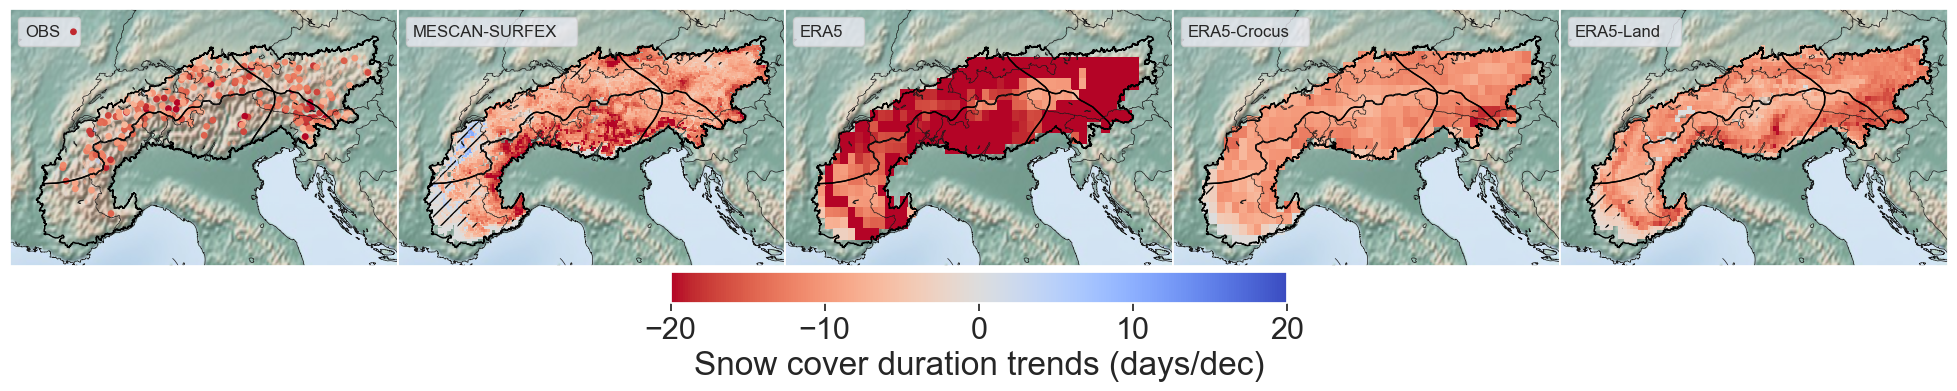

In [14]:
## Panel map 

if var == 'snd':
    cmap = 'coolwarm_r'
    vmin , vmax = -30,30
    
elif var == 'scd':
    cmap = 'coolwarm_r'
    vmin , vmax = -20,20
    
elif var == 'pr':
    cmap = 'coolwarm_r'
    vmin , vmax = -15,15

elif var == 'tas':
    cmap = 'coolwarm'
    vmin , vmax = -1.5,1.5
    
fig, ax = plt.subplots(1,len(list(ds_shaped.keys())),figsize = (25,8), sharex = True, sharey = True)
plt.subplots_adjust(wspace=0, hspace=0)

sns.set(font_scale = 2.)

for i, ax in enumerate(fig.axes):
    # Map background
    m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax)
    m2.drawcountries(linewidth = 0.5)
    m2.drawcoastlines(linewidth = 0.5)
    m2.shadedrelief()

    # Scatterplot for in situ obs
    if (var == 'snd' or var == 'scd') and list(ds_shaped.keys())[i] == 'OBS':
        smap = m2.scatter(ds[list(ds_shaped.keys())[i]].lon,ds[list(ds_shaped.keys())[i]].lat, c = ds_shaped[list(ds_shaped.keys())[i]]['slope'],vmin = vmin,vmax = vmax,cmap = cmap, s = 5, marker = 'd', alpha = 0.4)
        m2.scatter(ds[list(ds_shaped.keys())[i]].lon,ds[list(ds_shaped.keys())[i]].lat, c = ds_shaped[list(ds_shaped.keys())[i]]['slope'].where(ds_shaped[list(ds_shaped.keys())[i]]['loslope']*ds_shaped[list(ds_shaped.keys())[i]]['hislope'] > 0),vmin = vmin,vmax = vmax,cmap = cmap, label =list(ds_shaped.keys())[i], s = 15)
    
    else:
        # Plot all trends
        smap = m2.pcolor(ds[list(ds_shaped.keys())[i]].lon,ds[list(ds_shaped.keys())[i]].lat,ds_shaped[list(ds_shaped.keys())[i]]['slope'],vmin = vmin,vmax = vmax,cmap = cmap, label = list(ds_shaped.keys())[i]);  

        # Plot significative trends (uncertainties does not cross 0)
        m2.pcolor(ds[list(ds_shaped.keys())[i]].lon,ds[list(ds_shaped.keys())[i]].lat,ds_shaped[list(ds_shaped.keys())[i]]['slope'].where(ds_shaped[list(ds_shaped.keys())[i]]['loslope']*ds_shaped[list(ds_shaped.keys())[i]]['hislope'] > 0),vmin = vmin,vmax = vmax,cmap = cmap, label = None);  
        ax.contourf(ds[list(ds_shaped.keys())[i]].lon,ds[list(ds_shaped.keys())[i]].lat,ds_shaped[list(ds_shaped.keys())[i]]['slope'].where(ds_shaped[list(ds_shaped.keys())[i]]['loslope']*ds_shaped[list(ds_shaped.keys())[i]]['hislope'] < 0),vmin = vmin,vmax = vmax,colors = 'None',levels = 1,hatches = ['//'], zorder = 15, label = None)
    
    # Boundaries of the shapefile
    shp.plot(ax=ax,color='None', edgecolor='black', linewidth =1)
    
    # Limits of the map and legend size
    ax.set( ylim = (43,49),xlim =(4,17), xticks = [], yticks = [])
    ax.legend(prop={'size': 12}, handlelength=0, loc = 'upper left',fontsize = 40, markerfirst = False)

fig.colorbar(smap,ax = list(fig.axes), orientation = 'horizontal', label = (var_name+' trends ('+unit+'/dec)'), fraction = 0.05, pad = 0.01)
plt.savefig(output_path+'Panel_'+var+'_trends_'+period+'.png',dpi = 300, bbox_inches = 'tight')

# Methods, section 2

## Study domain with DEM

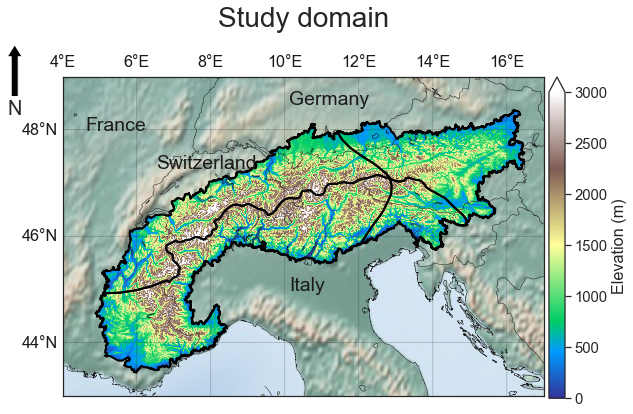

In [398]:
# Load DEM
MNT = u.applied_mask_from_shp(xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/MNT_1km/SRTM_DEM_1km.nc'),shp_path, 'y','x').mean(dim = 'region')

# Plot the study domain background
sns.set(font_scale = 1.35)
sns.set_style('white')

fig, ax = plt.subplots(figsize = (9,7))

m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax)
m2.drawparallels(np.arange(40,50,2),labels=[True,False,False,False], linewidth = 0.4)
m2.drawmeridians(np.arange(0,17,2),labels=[False,True,True,False], linewidth = 0.4)
m2.drawcountries(linewidth = 0.5)
m2.drawcoastlines(linewidth = 0.5)
m2.shadedrelief()

# North arrow
x, y, arrow_length = -0.1, 1.1, 0.2
plt.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=7, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Plot the DEM
im = m2.pcolor(MNT.x,MNT.y,MNT.z, cmap = 'terrain', vmin = 0, vmax = 3000)
shp.plot(ax=ax,color='None', edgecolor='black', linewidth =2)

# Annotate with surrounding contries
ax.annotate('France',(6.5,48),xycoords='data',
            xytext=(-70, -1), textcoords='offset points', color ='k' ,arrowprops=None, fontsize = 'large')

ax.annotate('Switzerland',(8.4,47.3),xycoords='data',
            xytext=(-70, -1), textcoords='offset points', color ='k' ,arrowprops=None, fontsize = 'large')

ax.annotate('Germany',(12,48.5),xycoords='data',
            xytext=(-70, -1), textcoords='offset points', color ='k' ,arrowprops=None, fontsize = 'large')

ax.annotate('Italy',(12,45),xycoords='data',
            xytext=(-70, -1), textcoords='offset points', color ='k' ,arrowprops=None, fontsize = 'large')

fig.colorbar(im,ax = ax, label = 'Elevation (m)', fraction = 0.032,pad=0.01, extend = 'max')
plt.title('Study domain', fontsize = 'xx-large', pad = 50)
plt.savefig(output_path+'Map_study_area_MNT_1km.png', dpi = 300, bbox_inches = 'tight')

## Location of observations and their elevational distribution

In [100]:
## Load and save the different subsample of in situ observations used for each part

data_path = '/cnrm/cen/users/NO_SAVE/monteirod/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/HISTALP_Alps/'
shp = geopandas.read_file(shp_path)
ls_month = [11,12,1,2,3,4]

var = 'scd'
section = 'trend'

## Load Obs matiu
ds = xr.load_dataset(data_path+'Reference_Dataset/SND_OBS/OBS_Matiu/snd_Alps_1961_2020.nc')
ds = ds.drop(['HS_after_qc'])
ds['snd'] = ds['snd']/100

## OBS for the reference characteristics of the snow cover, section 3.1
## Here we take all the data 
if section == 'reference':

    ds = ds.sel(time = slice('1985','2015')).dropna(dim = 'Station_Name', how ='all')

## OBS for SCD, temporal analyses, section 3.2
## For this part, all the obs that are continuous over the period
elif section == 'seasonality':

    ds = ds.sel(time = slice('2000','2015')).dropna(dim = 'Station_Name', how ='all')

    ## Only keep station that have a record at least 80% of the time for all month
    station_record_length = (ds.snd.count(dim = 'time')/len(ds.time))*100
    station_record_length = station_record_length.where(station_record_length > 80).dropna(dim = 'Station_Name')
    ds = ds.sel(Station_Name = station_record_length.Station_Name)


## OBS for the computation of trends and interannual variability, section 3.3
## Here we keep data with at least 90% for a winter season for each of the 50 years
elif section == 'trend':

    ds = ds.sel(time = slice('1968','2018')).dropna(dim = 'Station_Name', how ='all')
    
    ds_i = ds.isel(time=ds.time.dt.month.isin(ls_month))

    # ## Only keep station that have a record at least 90% of the time during winter months
    station_record_length = (ds_i.snd.count(dim = 'time')/len(ds_i.time))*100
    station_record_length = station_record_length.where(station_record_length > 90).dropna(dim = 'Station_Name')
    ds = ds.sel(Station_Name = station_record_length.Station_Name)

## Saved it

if var == 'scd':
    ds = u.applied_mask_from_shp(ds,shp_path,'lat','lon', shp['NAME']).drop(['abbrevs','names']).dropna(dim = 'Station_Name', how = 'all').mean(dim = 'region')
    ds = ds.snd.resample(time = 'A-SEP', closed = 'left',label = 'left').map(u.lcscd, threshold = 0.01)
    ds.to_netcdf('/cnrm/cen/users/NO_SAVE/monteirod/dataset_monthly/scd/scd_OBS_insitu_'+section+'.nc')
else:
    ds = ds.resample(time = '1MS', closed = 'left',label = 'left').mean()
    ds = u.applied_mask_from_shp(ds,shp_path,'lat','lon', shp['NAME']).drop(['abbrevs','names']).dropna(dim = 'Station_Name', how = 'all').mean(dim = 'region')
    ds.to_netcdf('/cnrm/cen/users/NO_SAVE/monteirod/dataset_monthly/snd/snd_OBS_insitu_'+section+'.nc')


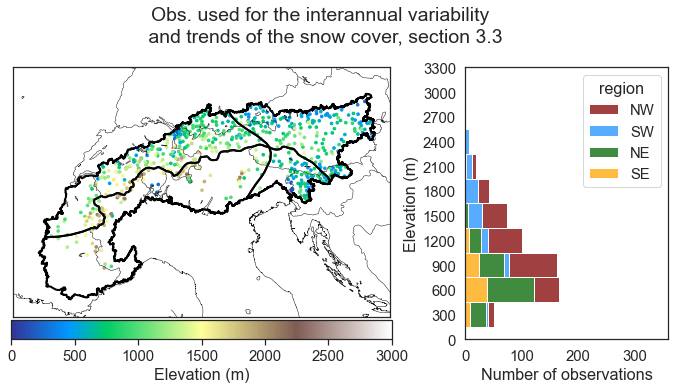

In [15]:
## Plot the map 

output_path = '/home/monteirod/tmp/Comparison_UE_Alps/'
from matplotlib.gridspec import GridSpec

sns.set(font_scale = 1.35)
sns.set_style('white')

fig = plt.figure(figsize = (12,5))
gs = GridSpec(1, 2, width_ratios=[2,1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

m2 = Basemap(llcrnrlon=4,llcrnrlat=43,urcrnrlon=17.,urcrnrlat=49, epsg = 4326, lat_0 = 43.5, lon_0 = 5, resolution = 'h', ax = ax1)
m2.drawcountries(linewidth = 0.5)
m2.drawcoastlines(linewidth = 0.5)

# Plot the location of observations and shapefile boundaries
im = m2.scatter(ds.lon,ds.lat,c = ds.ZS, cmap = 'terrain', s = 7, vmin = 0, vmax = 3000)
shp.plot(ax=ax1,color='None', edgecolor='black', linewidth =2)

fig.colorbar(im,ax = ax1, orientation = 'horizontal', label = 'Elevation (m)', fraction = 0.07,pad=0.01)

### Plot the histogram

ls_month = [1,2,3,4,5,6,7,8,9,10,11,12]
ls_month_name = ['J','F','M','A','M','J','J','A','S','O','N','D']
period = ''.join(ls_month_name[i-1] for i in ls_month)

ls_alt = np.arange(-150,3600,300)
ds_shaped = u.per_alt(ds.isel(time=ds.time.dt.month.isin(ls_month)).mean(dim = 'time'),ls_alt)
ds_shaped = u.applied_mask_from_shp(ds_shaped,shp_path,'lat','lon', shp['NAME']).drop(['abbrevs','names'])
ds_shaped['middle_slices_ZS'] = ds_shaped['middle_slices_ZS'] -150# To centered the bin

## Plot the histogram

hist_ZS = []
df = ds_shaped[var].to_dataframe().reset_index()[['region',var,'middle_slices_ZS']].dropna()
hist_ZS = df.reset_index()[['middle_slices_ZS','region',var]].melt(id_vars = ['region','middle_slices_ZS'])

sns.set_style("ticks")
g = sns.histplot(hist_ZS, y = "middle_slices_ZS", hue = 'region',hue_order =['NW','SW','NE','SE'], multiple ='stack',binwidth=300, palette = ['maroon','dodgerblue','darkgreen','orange'], ax = ax2)

g.set(yticks = ds_shaped.middle_slices_ZS+150)
g.set_ylim(0,3300)
plt.xlabel('Number of observations')
plt.ylabel('Elevation (m)')
plt.xlim(0,360)

if section == 'reference':
    fig.suptitle("Obs. used for the reference characteristics \n of the snow cover, section 3.1",y=1.05)
if section == 'seasonality':
    fig.suptitle("Obs. used for the analyses \n of the snow cover seasonality, section 3.2",y=1.05)
if section == 'trend':
    fig.suptitle("Obs. used for the interannual variability \n and trends of the snow cover, section 3.3",y=1.05)
    
plt.savefig(output_path+'Repartition_of_SND_obs_per_elevation_'+section+'.pdf', bbox_inches= 'tight')

## Elevation distribution of DEM at 100m and relative biases of the different datasets

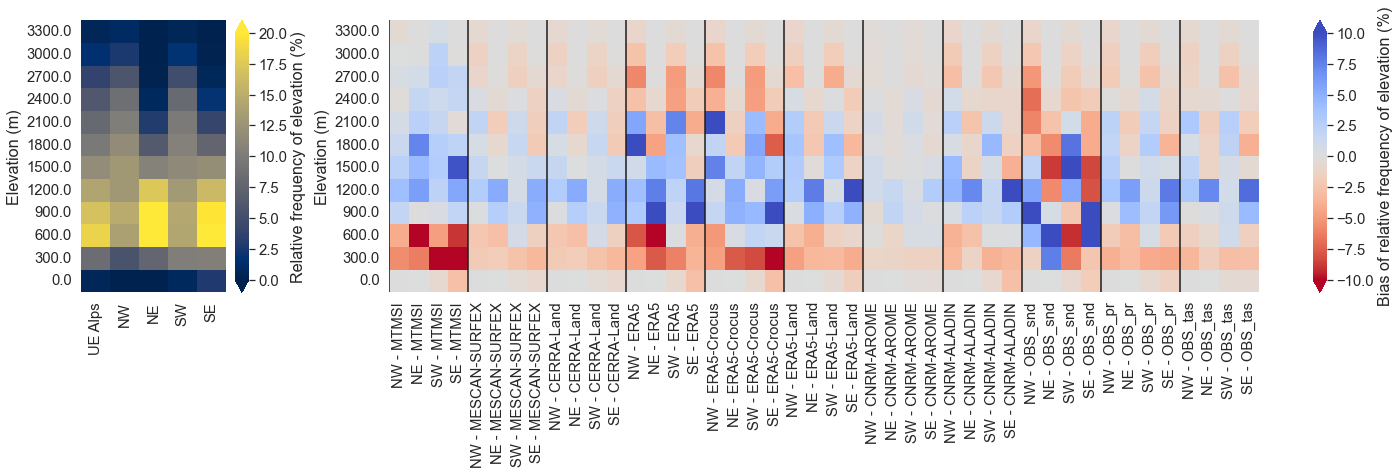

In [70]:
# Relative frequency of observations per elevation

data_path = '/cnrm/cen/users/NO_SAVE/monteirod/dataset_monthly/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/HISTALP_Alps/'
shp = geopandas.read_file(shp_path)

var = 'snd'

ls_name = {
    'MTMSI': 'MTMSI',
    'MESCAN-SURFEX': 'UERRA',
    'CERRA-Land': "CERRA_Land",
    "ERA5": 'ERA5',
    'ERA5-Crocus': 'ERA5_CROCUS',
    'ERA5-Land': 'ERA5_Land',
    "CNRM-AROME": 'AROME',
    'CNRM-ALADIN': 'ALADIN'}

ls_spatial_dim = {
    'MTMSI': ['Number_of_points'],
    'MESCAN-SURFEX': ['x', 'y'],
    'CERRA-Land': ['x', 'y'],
    "ERA5": ['lat', 'lon'],
    'ERA5-Crocus': ['lat', 'lon'],
    'ERA5-Land': ['lat', 'lon'],
    "CNRM-AROME": ['x', 'y'],
    'CNRM-ALADIN': ['x', 'y']}

# Load all datasets and divide them in subregions

ds = {}

for i in range(0, len(list(ls_name.values()))):
    ds[list(ls_name.keys())[i]] = xr.open_dataset(data_path+var+'/'+var+'_' +
                                                  list(ls_name.values())[i]+'.nc').sel(time=slice('1985', '2014'))
    ds[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds[list(ls_name.keys())[i]],
                                                          shp_path, 'lat', 'lon', shp['NAME']).drop(['abbrevs', 'names'])

var = 'snd'
ls_name['OBS_snd'] = "OBS_insitu_reference"
ls_spatial_dim['OBS_snd'] = ['Station_Name']
ds['OBS_snd'] = xr.open_dataset(data_path+var+'/'+var+'_'+ls_name['OBS_snd']+'.nc').sel(time=slice('1985', '2014'))

var = 'pr'
ls_name['OBS_pr'] = "LAPrec"
ls_spatial_dim['OBS_pr'] = ['x', 'y']
ds['OBS_pr'] = xr.open_dataset(data_path+var+'/'+var+'_'+ls_name['OBS_pr']+'.nc').sel(time=slice('1985', '2014'))

var = 'tas'
ls_name['OBS_tas'] = "E_OBS"
ls_spatial_dim['OBS_tas'] = ['lon', 'lat']
ds['OBS_tas'] = xr.open_dataset(data_path+var+'/'+var+'_'+ls_name['OBS_tas']+'.nc').sel(time=slice('1985', '2014'))

## Prepare evaluated datasets
ls_alt = np.arange(-150, 3600, 300)

ds_shaped = {}
Bias = {}

for i in range(0, len(list(ls_name.values()))):
    ds_shaped[list(ls_name.keys())[i]] = u.applied_mask_from_shp(
        ds[list(ls_name.keys())[i]]['ZS'], shp_path, 'lat', 'lon', shp['NAME'])
    ds_shaped[list(ls_name.keys())[i]] = u.per_alt(ds_shaped[list(ls_name.keys())[i]],
                                                   ls_alt).count(dim=ls_spatial_dim[list(ls_name.keys())[i]])
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]] / \
        ds_shaped[list(ls_name.keys())[i]].sum(dim='middle_slices_ZS')*100

# Define the reference
ref = xr.load_dataset('/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/MNT_25m/MNT100m_counter.nc').drop(['abbrevs','names'])
ref['number'] = ref.ZS
ref['relative'] = ref.number/ref.number.sum(dim='middle_slices_ZS')*100
ref_all = ref.sum(dim = 'region')
ref_all['region'] = 'UE Alps'
ref_all['relative'] = ref_all.number/ref_all.number.sum(dim='middle_slices_ZS')*100
ref_all = ref_all.assign_coords({'region':'UE Alps'})
ref_all = xr.concat([ref_all,ref], dim = 'region')

df_ref = ref_all['relative'].to_dataframe().reset_index()
df_ref.region=pd.Categorical(df_ref.region,categories=['UE Alps','NW','NE','SW','SE'],ordered=True)
df_ref = df_ref.pivot_table(index = 'middle_slices_ZS', columns = ['region']).sort_index(level ='middle_slices_ZS', ascending = False, sort_remaining=False) # index by descending elevation band, then Datasets# 

# Compute biases 
for i in range(0, len(list(ls_name.values()))):
    Bias[list(ls_name.keys())[i]] = (ds_shaped[list(ls_name.keys())[i]] - ref.relative)

df = []
for i in range(0, len(list(ls_name.values()))):
    df_i = Bias[list(ls_name.keys())[i]].rename('ZS').to_dataframe().reset_index()[['region', 'ZS', 'middle_slices_ZS']].dropna()
    df.append(df_i)
df = pd.concat(df, keys=list(ls_name.keys()))

df = df.reset_index().rename(columns = {'level_0':'Dataset'})[['Dataset','region','middle_slices_ZS','ZS']]

# Used to block the ordering of columns
df.Dataset=pd.Categorical(df.Dataset,categories=df.Dataset.unique(),ordered=True)
df.region=pd.Categorical(df.region,categories=['NW','NE','SW','SE'],ordered=True)

df = df.pivot_table(index = 'middle_slices_ZS', columns = ['Dataset','region']).sort_index(level ='middle_slices_ZS', ascending = False, sort_remaining=False) # index by descending elevation band, then Datasets# 

## Plot the heatmaps

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (25,5))
gs = GridSpec(1, 2, width_ratios=[1,6])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

cmap = 'cividis'
g = sns.heatmap(df_ref, annot=False,robust = True,vmin = 0, vmax = 20,cmap = cmap,cbar_kws={'label': 'Relative frequency of elevation (%)',"extend":'both'}, ax = ax1)
ax1.grid(True, alpha = 0.2)
ax1.set_xlabel('')
ax1.set_ylabel('Elevation (m)')
ax1.set_xticklabels([df_ref.columns[i][1] for i in range(0,len(df_ref.columns))]);

###########

cmap = plt.get_cmap('coolwarm_r')
g = sns.heatmap(df, annot=False, robust=True, vmin=-10, vmax=10, cmap=cmap, cbar_kws={'label': 'Bias of relative frequency of elevation (%)',"extend": 'both'}, ax = ax2)
ax2.vlines(np.arange(0, len(ds_shaped.keys())*4, 4), *ax.get_ylim(), color='k')
ax2.grid(True, alpha=0.2)
ax2.set_xlabel('')
ax2.set_ylabel('Elevation (m)')
ax2.set_xticklabels([df.columns[i][2]+' - '+df.columns[i][1] for i in range(0,len(df.columns))]);

plt.savefig(output_path+'Relative_frequency_bias.pdf', bbox_inches = 'tight')

# Determination of the snow depth threshold : MODIS NDSI vs. in situ observations, section 2.4.3

## Load and save dataset 

In [83]:
### Create datasets and save them ###

ls_year = [2000,2015]
data_path = '/cnrm/cen/users/NO_SAVE/monteirod/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/HISTALP_Alps/'

## Obs matiu
obs_snd = xr.open_dataset(data_path+'Reference_Dataset/SND_OBS/OBS_Matiu/snd_Alps_1961_2020.nc').sel(time = slice(str(ls_year[0])+'-09',str(ls_year[-1]))).dropna(dim = 'Station_Name',how = 'all')

## Load and save MODIS 
modis = xr.open_mfdataset(data_path+'Reference_Dataset/MOD10A1_NSIDC/netCDF/MOD10A1F_CGF_NSIDC_*.nc', chunks = 'auto', combine = 'nested',concat_dim='time', coords = 'minimal', data_vars='minimal').rename({'x':'lon','y':'lat'}).drop('band').sel(time = slice(str(ls_year[0])+'-09',str(ls_year[-1])))

oro = xr.open_dataset(data_path+'/Reference_Dataset/MOD10A1_NSIDC/fx/DEM_MODIS_NSIDC.nc').rename({'Band1':'ZS'})
oro['lat'] = list(reversed(modis['lat']))
oro['lon'] = modis['lon']

modis = xr.merge([modis, oro]).set_coords('ZS')

## Only keep station that have a record at least 80% of the time
station_record_length = (obs_snd.snd.count(dim = 'time')/len(obs_snd.time))*100
station_record_length = station_record_length.where(station_record_length > 80).dropna(dim = 'Station_Name')
obs_snd = obs_snd.sel(Station_Name = station_record_length.Station_Name)

## Keep station inside Alps conv shp
obs_snd = u.applied_mask_from_shp(obs_snd,shp_path).mean(dim ='region').dropna(dim = 'Station_Name', how = 'all') 

## Load MODIS at obs point ##
modis_station = []
for i in range(0,len(obs_snd['Station_Name'])):
    modis_station.append(modis.sel(lat = obs_snd.lat[i], lon = obs_snd.lon.values[i], method = 'nearest'))
modis_station = xr.concat(modis_station,dim = 'Station_Name')
modis_station['Station_Name'] = obs_snd['Station_Name']

## Remove values where there are too much difference in altitude
modis_station = modis_station.where(np.abs(modis_station.ZS - obs_snd.ZS) < 100).dropna(dim = 'Station_Name', how ='all')
obs_snd = obs_snd.sel(Station_Name = modis_station.Station_Name)



KeyboardInterrupt



## Compare skill scores for binary SCD

In [2]:
## Load dataset 

ls_year = [2000,2015]
obs_snd = xr.open_dataset('/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/MOD10A1_NSIDC/netCDF/OBS_used_in_sensitivity_studies_threshold.nc')
modis_station = xr.open_dataset('/cnrm/cen/users/NO_SAVE/monteirod/Reference_Dataset/MOD10A1_NSIDC/netCDF/MODIS_at_obs_stations.nc')

# subsample stations at a certain elevation only
obs_snd = u.per_alt(obs_snd,np.arange(-150,3000,300)).sel(middle_slices_ZS = slice(600,2400)).mean(dim = 'middle_slices_ZS').dropna(how = 'all', dim = 'Station_Name')
modis_station = modis_station.sel(Station_Name = obs_snd.Station_Name)

## Distribution of elevation differences between in situ observations and MODIS
# plt.boxplot(modis_station.ZS-obs_snd.ZS)

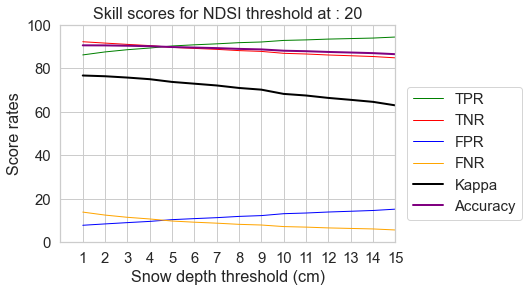

In [5]:
## Calculate detection score by comparing what is detected as snow covered or not

modis = modis_station.NDSI.stack(z = ['Station_Name','time'])
obs = obs_snd.snd.stack(z = ['Station_Name','time'])

ls_ndsi_treshold = [20]
ls_snd_treshold = np.arange(1,16,1)

sns.set(font_scale = 1.35)
sns.set_style('whitegrid')

fig, ax = plt.subplots(len(ls_ndsi_treshold),1,sharex = True,sharey = True, figsize = (6,4))

for j, ax in enumerate(fig.axes):
    TPR = []
    TNR = []
    FPR = []
    FNR = []
    kappa = []
    accuracy = []
    
    ndsi_treshold = ls_ndsi_treshold[j]

    for i in range(0,len(ls_snd_treshold)):
        
        snd_treshold = ls_snd_treshold[i]

        modis_i = np.asarray(xr.where(modis > ndsi_treshold,1,0))
        obs_i = np.asarray(xr.where(obs > snd_treshold,1,0))

        TP = np.logical_and(modis_i == 1, obs_i == 1).sum()
        TN = np.logical_and(modis_i == 0, obs_i == 0).sum()
        FP = np.logical_and(modis_i == 1, obs_i == 0).sum()
        FN = np.logical_and(modis_i == 0, obs_i == 1).sum()
        
        TPR.append(TP/(TP+FN))
        TNR.append(TN/(TN+FP))
        FPR.append(FP/(FP+TN))
        FNR.append(FN/(FN+TP))
        
        accuracy.append((TP+TN)/(TP+TN+FP+FN))
        kappa.append((2*(TP*TN - FN*FP))/((TP+FP)*(FP+TN) + (TP+FN)*(FN+TN)))

    TPR = np.asarray(TPR)
    TNR = np.asarray(TNR)
    FPR = np.asarray(FPR)
    FNR = np.asarray(FNR)
    kappa = np.asarray(kappa)
    accuracy = np.asarray(accuracy)
    
    ax.plot(ls_snd_treshold,TPR*100, label = 'TPR', color = 'green',lw = 1)
    ax.plot(ls_snd_treshold,TNR*100, label = 'TNR', color = 'red',lw = 1)
    ax.plot(ls_snd_treshold,FPR*100, label = 'FPR',color = 'blue',lw = 1)
    ax.plot(ls_snd_treshold,FNR*100, label = 'FNR',color ='orange',lw = 1)
    ax.plot(ls_snd_treshold,kappa*100, label = 'Kappa',color ='black', lw = 2)
    ax.plot(ls_snd_treshold,accuracy*100, label = 'Accuracy',color ='purple', lw = 2)

    ax.set_title('Skill scores for NDSI threshold at : '+str(ndsi_treshold))
    ax.grid(True)
    ax.set_ylim(0,100)
    ax.set_ylabel('Score rates')
    ax.set_xlabel('Snow depth threshold (cm)')
    plt.xlim(0,15)
    plt.xticks(ls_snd_treshold)

plt.legend(bbox_to_anchor=(1.4, 0.75))

plt.savefig(output_path+'Detection_metrics_binary_modis_'+str(ls_ndsi_treshold[0])+'.pdf', bbox_inches='tight')

## Compared error metrics for SOD MOD and SCD

0


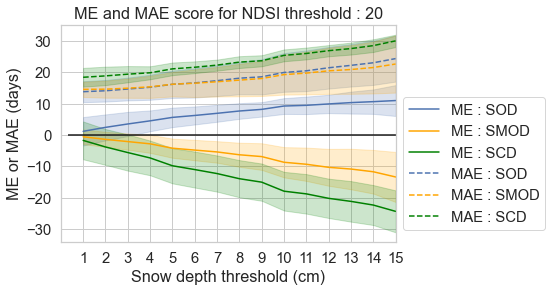

In [9]:
## Sensitivity 

sns.set(font_scale = 1.35)
sns.set_style('whitegrid')
ndsi_threshold = [20]

for k in range(0,len(ndsi_threshold)):
    print(k)
    
    #### Calculate scd modis
    scd_modis = modis_station.NDSI.sel(time = slice(str(ls_year[0])+'-09',str(ls_year[-1]))).resample(time = 'A-SEP', closed = 'left', label = 'left').map(u.lcscd, threshold = ndsi_threshold[k]).isel(time = slice(1,None))
    scd_modis['sod'] = (['time']+['Station_Name'],[(mdates.date2num(scd_modis['sod'].sel(time = str(j))) - (np.datetime64(str(int(scd_modis.sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in scd_modis.time.dt.year.values])
    scd_modis['mod'] = (['time']+['Station_Name'],[(mdates.date2num(scd_modis['mod'].sel(time = str(j))) - (np.datetime64(str(int(scd_modis.sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in scd_modis.time.dt.year.values])

    #### Calculate scd obs
    ls_treshold = np.arange(1,16,1)

    scd_obs_all = []

    for i in range(0,len(ls_treshold)):
        scd_obs = obs_snd.snd.sel(time = slice(str(ls_year[0])+'-09',str(ls_year[-1]))).resample(time = 'A-SEP', closed = 'left', label = 'left').map(u.lcscd, threshold = ls_treshold[i]).isel(time = slice(1,None))
        scd_obs['sod'] = (['time']+['Station_Name'],[(mdates.date2num(scd_obs['sod'].sel(time = str(j))) - (np.datetime64(str(int(scd_obs.sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in scd_obs.time.dt.year.values])
        scd_obs['mod'] = (['time']+['Station_Name'],[(mdates.date2num(scd_obs['mod'].sel(time = str(j))) - (np.datetime64(str(int(scd_obs.sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in scd_obs.time.dt.year.values])
        scd_obs_all.append(scd_obs)
    scd_obs_all = xr.concat(scd_obs_all, dim = 'Threshold')
    scd_obs_all['Threshold'] = ls_treshold

    scd_obs_all = u.per_alt(scd_obs_all,np.arange(-150,3300,300)).sel(middle_slices_ZS = slice(600,2400))
    scd_modis = u.per_alt(scd_modis,np.arange(-150,3300,300)).sel(middle_slices_ZS = slice(600,2400))
    
    scd_obs = scd_obs_all.stack(z = ['time','Station_Name'])
    scd_modis = scd_modis.stack(z = ['time','Station_Name'])
    
    ## Compute error metrics : MAE and ME
    rmse = []
    bias = []
    mae = []
    
    for i in range(0,len(ls_treshold)):
        rmse.append(np.sqrt(np.square(scd_modis - scd_obs.sel(Threshold = ls_treshold[i])).mean(dim = "z")))
        mae.append(np.abs((scd_obs.sel(Threshold = ls_treshold[i]) - scd_modis)))
        bias.append((scd_obs.sel(Threshold = ls_treshold[i]) - scd_modis))
    rmse = xr.concat(rmse,dim ='Threshold')
    bias = xr.concat(bias, dim = 'Threshold')
    mae = xr.concat(mae, dim = 'Threshold')
    df_bias = pd.concat([bias.sod.rename('bias').to_dataframe().reset_index(),bias.mod.rename('bias').to_dataframe().reset_index(),bias.scd.rename('bias').to_dataframe().reset_index()], keys = ['sod','mod','scd']).reset_index().rename(columns={'level_0':'BIAS'})
    df_mae = pd.concat([mae.sod.rename('mae').to_dataframe().reset_index(),mae.mod.rename('mae').to_dataframe().reset_index(),mae.scd.rename('mae').to_dataframe().reset_index()], keys = ['sod','mod','scd']).reset_index().rename(columns={'level_0':'MAE'})


    ## Plot
    
    sns.set_style('whitegrid')
    plt.figure()
    
    # ME
    ax = sns.lineplot(data = bias.mean(dim = 'z').sod.to_dataframe().reset_index(),y = 'sod',ci = 'sd', x = 'Threshold', color ='b', label = 'ME : SOD')
    sns.lineplot( data = bias.mean(dim = 'z').mod.to_dataframe().reset_index(),y = 'mod',ci = 'sd', x = 'Threshold', color ='orange', label = 'ME : SMOD')
    sns.lineplot( data = bias.mean(dim = 'z').scd.to_dataframe().reset_index(),y = 'scd',ci = 'sd', x = 'Threshold', color = 'green', label = 'ME : SCD')
    
    # MAE
    sns.lineplot( data = mae.mean(dim = 'z').sod.to_dataframe().reset_index(),y = 'sod',ci = 'sd', x = 'Threshold', color ='b', ls = '--',label = 'MAE : SOD')
    sns.lineplot( data = mae.mean(dim = 'z').mod.to_dataframe().reset_index(),y = 'mod',ci = 'sd', x = 'Threshold', color ='orange', ls = '--',label = 'MAE : SMOD')
    sns.lineplot( data = mae.mean(dim = 'z').scd.to_dataframe().reset_index(),y = 'scd',ci = 'sd', x = 'Threshold', color = 'green', ls = '--',label = 'MAE : SCD')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
    
    plt.hlines(0,ax.get_xlim()[0],ax.get_xlim()[1], color = 'k')
    plt.grid(True)
    plt.title('ME and MAE score for NDSI threshold : '+str(ndsi_threshold[k]))
    plt.xlim(0,15)
    plt.xticks(ls_treshold)
    plt.xlabel('Snow depth threshold (cm)')
    plt.ylabel('ME or MAE (days)')
    
    plt.savefig(output_path+'ME_MAE_score_NDSI_threshold_'+str(ndsi_threshold[k])+'.pdf', bbox_inches='tight')
    

# Appendix : Graphs for each sub-regions

## Section 1 of the results : Boxplot and annual cycle

In [9]:
## Defined variable
var = 'snd'
yr_start = 1985
yr_end = 2015

## Path 
data_path = '/cnrm/cen/users/NO_SAVE/monteirod/dataset_monthly/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/HISTALP_Alps/'
shp = geopandas.read_file(shp_path)
output_path = '/home/monteirod/tmp/Comparison_UE_Alps/'

## List of dataset names : keys = label names ; values = file extension names
ls_name = {
    'MTMSI': 'MTMSI',
    'MESCAN-SURFEX': 'UERRA',
    'CERRA-Land': "CERRA_Land",
    "ERA5": 'ERA5',
    'ERA5-Crocus': 'ERA5_CROCUS',
    'ERA5-Land': 'ERA5_Land',
    "CNRM-AROME": 'AROME',
    'CNRM-ALADIN': 'ALADIN'}

## List of spatial dimension names : keys = label names ; values = dimension names list
ls_spatial_dim = {
    'MTMSI': ['Number_of_points'],
    'MESCAN-SURFEX': ['x', 'y'],
    'CERRA-Land': ['x', 'y'],
    "ERA5": ['lat', 'lon'],
    'ERA5-Crocus': ['lat', 'lon'],
    'ERA5-Land': ['lat', 'lon'],
    "CNRM-AROME": ['x', 'y'],
    'CNRM-ALADIN': ['x', 'y']}


## List of color for each datasets
lightness = 0.9
ls_name_color = {'OBS': 'black',
                 'MODIS': 'darkgray',
                 'MTMSI': 'yellowgreen',
                 'MESCAN-SURFEX': 'chartreuse',
                 'CERRA-Land': 'darkgreen',
                 "ERA5": 'gold',
                 'ERA5-Crocus': 'darkorange',
                 'ERA5-Land': 'brown',
                 "CNRM-AROME": u.adjust_lightness('mediumblue',
                                                  lightness),
                 'CNRM-ALADIN': u.adjust_lightness('lightblue',
                                                   lightness)}

## Modification of list depending on the variables investigated
if var == 'snd':
    ls_name['OBS'] = "OBS_insitu_reference"
    ls_spatial_dim['OBS'] = ['Station_Name']
    var_name = 'Snow depth'
    unit = '(m)'

elif var == 'pr':
    ls_name['OBS'] = "LAPrec"
    ls_spatial_dim['OBS'] = ['x', 'y']
    var_name = 'Precipitation'
    unit = '(mm/day)'

elif var == 'tas':
    ls_name['OBS'] = "E_OBS"
    ls_spatial_dim['OBS'] = ['lon', 'lat']
    var_name = 'Temperature'
    unit = '(°C)'
    

## Load raw pre-treated datasets into a dict without any treatment

ds = {}

for i in range(0, len(list(ls_name.values()))):
    ds[list(ls_name.keys())[i]] = xr.open_dataset(data_path+var+'/'+var+'_' +
                                                  list(ls_name.values())[i]+'.nc').sel(time = slice(str(yr_start),str(yr_end)))
    
    # Mask all data outside the boundaries of the Alpine convention
    ds[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds[list(ls_name.keys())[i]],shp_path, 'lat', 'lon', shp['NAME']).drop(['abbrevs', 'names']).mean(dim = 'region')

### Boxplot for the mean winter values distribution

In [10]:
## Treat dataset

ls_month = [11,12,1,2,3,4] # Selected months
ls_month_name = ['J','F','M','A','M','J','J','A','S','O','N','D']
period = ''.join(ls_month_name[i-1] for i in ls_month)
ls_alt = np.arange(-150,3300,300) # List of the boundaries for the elevation band
choosen_alt = [600,1500,2400] # List of the middle elevation band choosen

ds_shaped = {}

# Selection of months of interest only, elevation slicing, selection of elevation bands
for i in range(0,len(list(ls_name.values()))):
        
    ds_shaped[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]].isel(time=ds[list(ls_name.keys())[i]].time.dt.month.isin(ls_month)),ls_alt).sel(middle_slices_ZS = choosen_alt)
    # Select only complete season if they are overlapping from one year to the next
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[0]))+'-'+str(ls_month[0]),str(int(ds_shaped[list(ls_name.keys())[i]].time.dt.year[-1]))+'-'+str(ls_month[-1])))
    # Average over the 30 years for each point
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].mean(dim = 'time')
    ds_shaped[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds_shaped[list(ls_name.keys())[i]],shp_path, 'lat', 'lon', shp['NAME']).drop(['abbrevs', 'names'])

# Create the dataframe
df = []
for i in range(0,len(list(ls_name.values()))):
    df_i = ds_shaped[list(ls_name.keys())[i]][var].to_dataframe().reset_index().drop(columns = ls_spatial_dim[list(ls_name.keys())[i]]+['lat','lon','ZS']).dropna()
    df.append(df_i)
df = pd.concat(df, keys = list(ls_name.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})


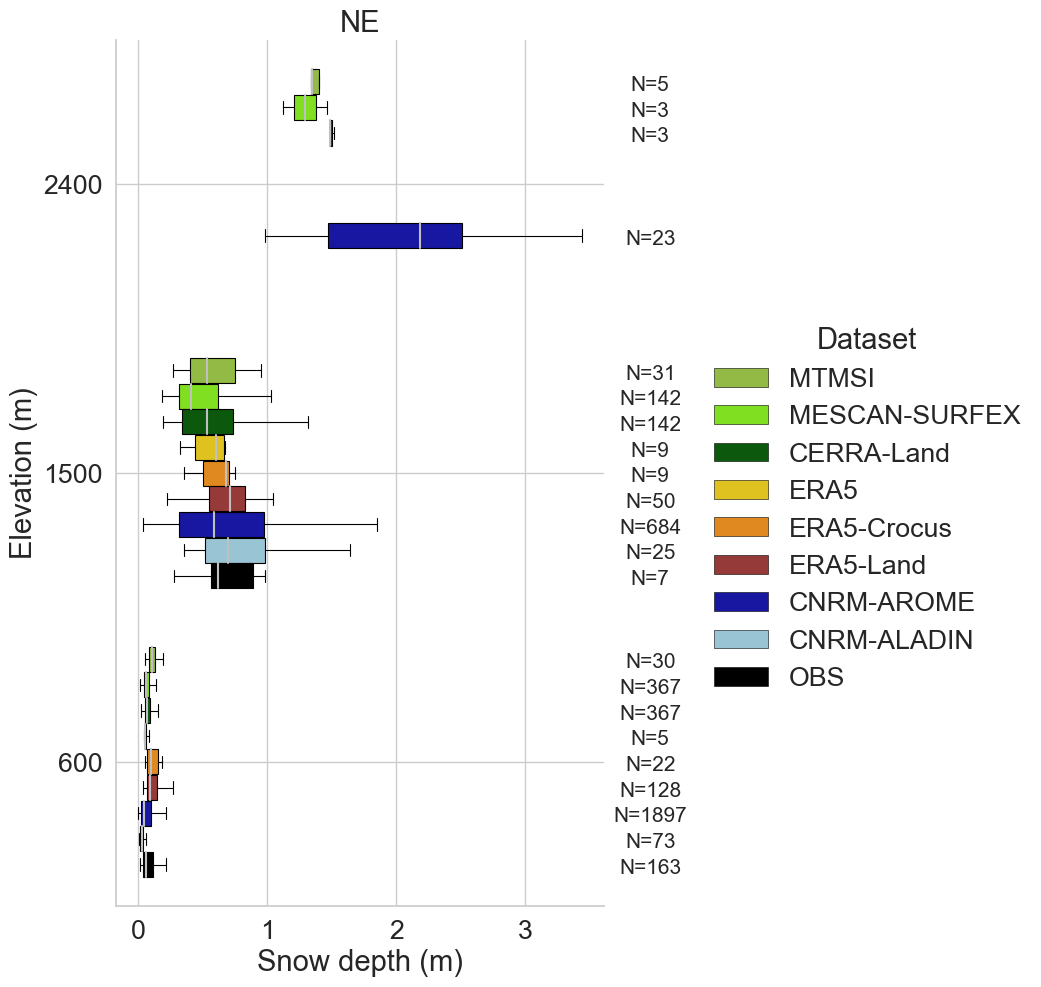

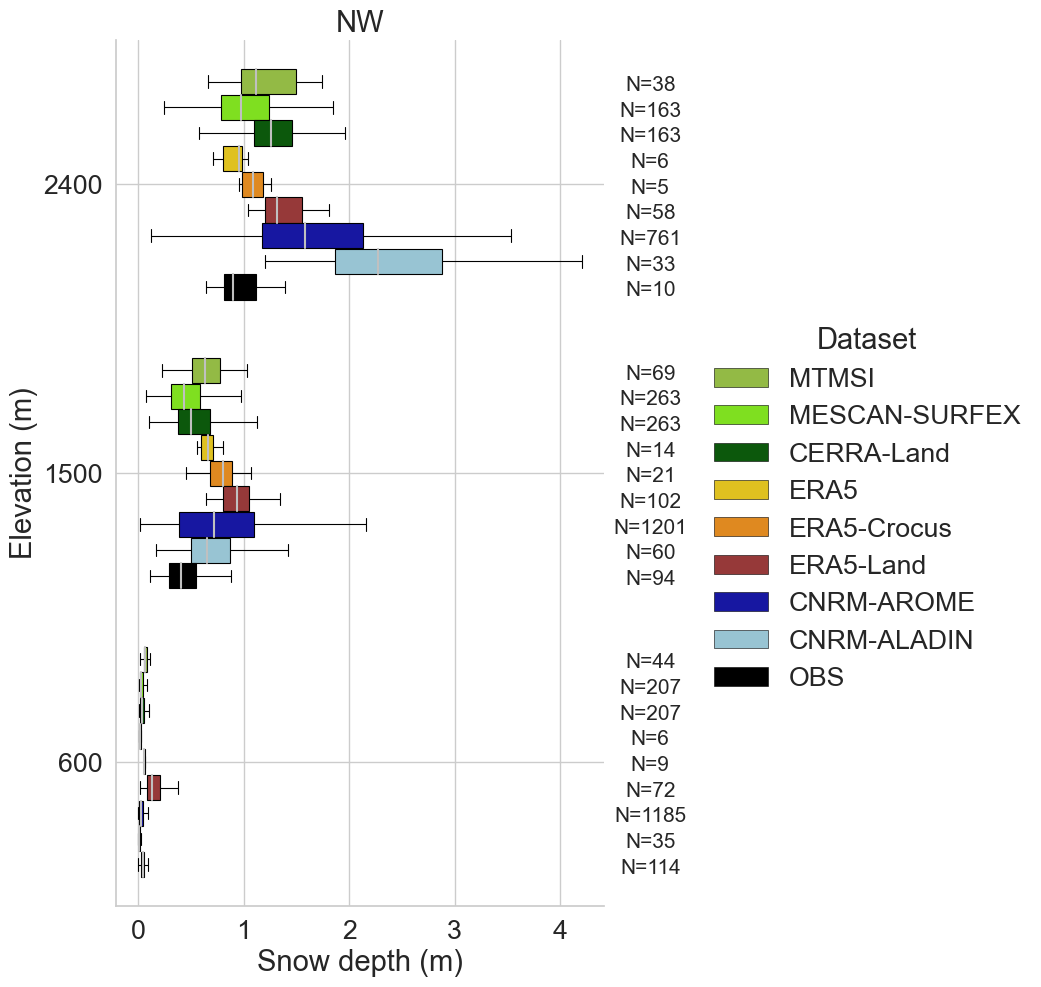

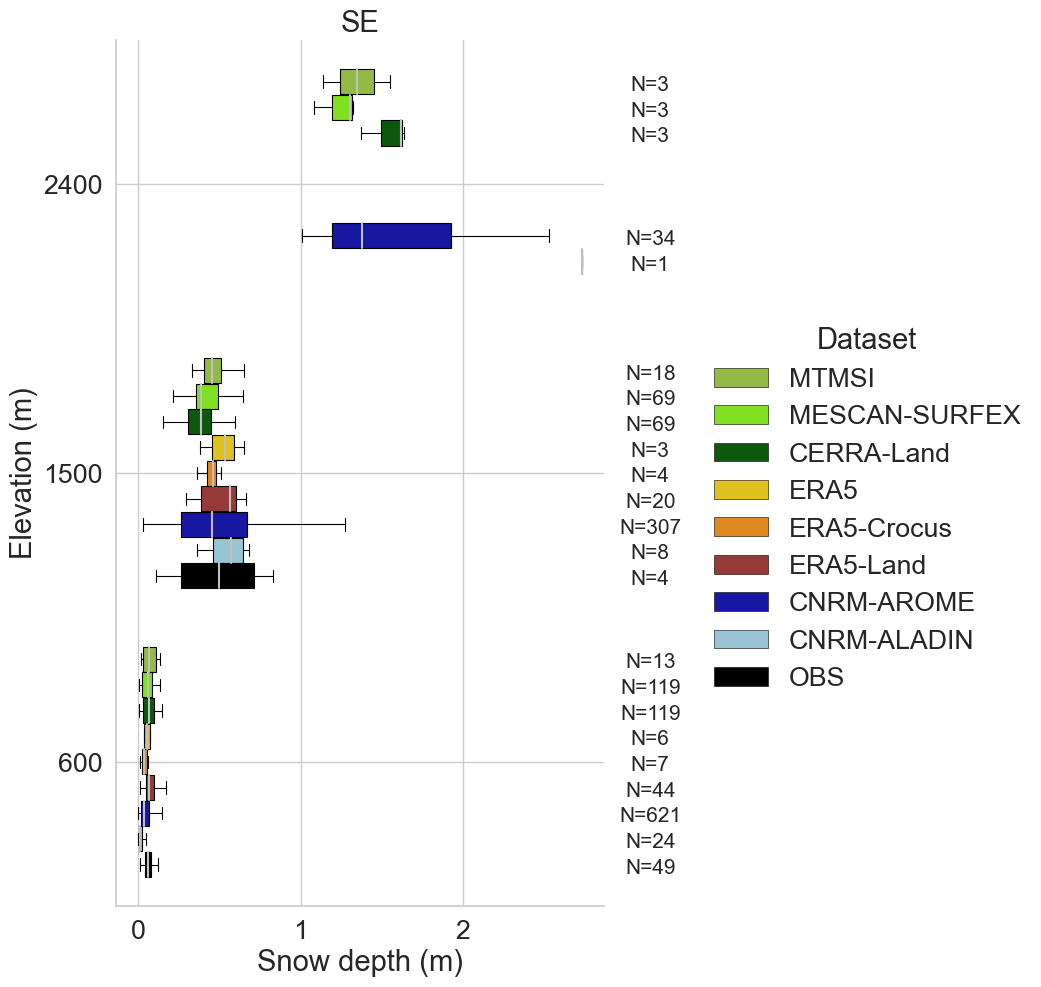

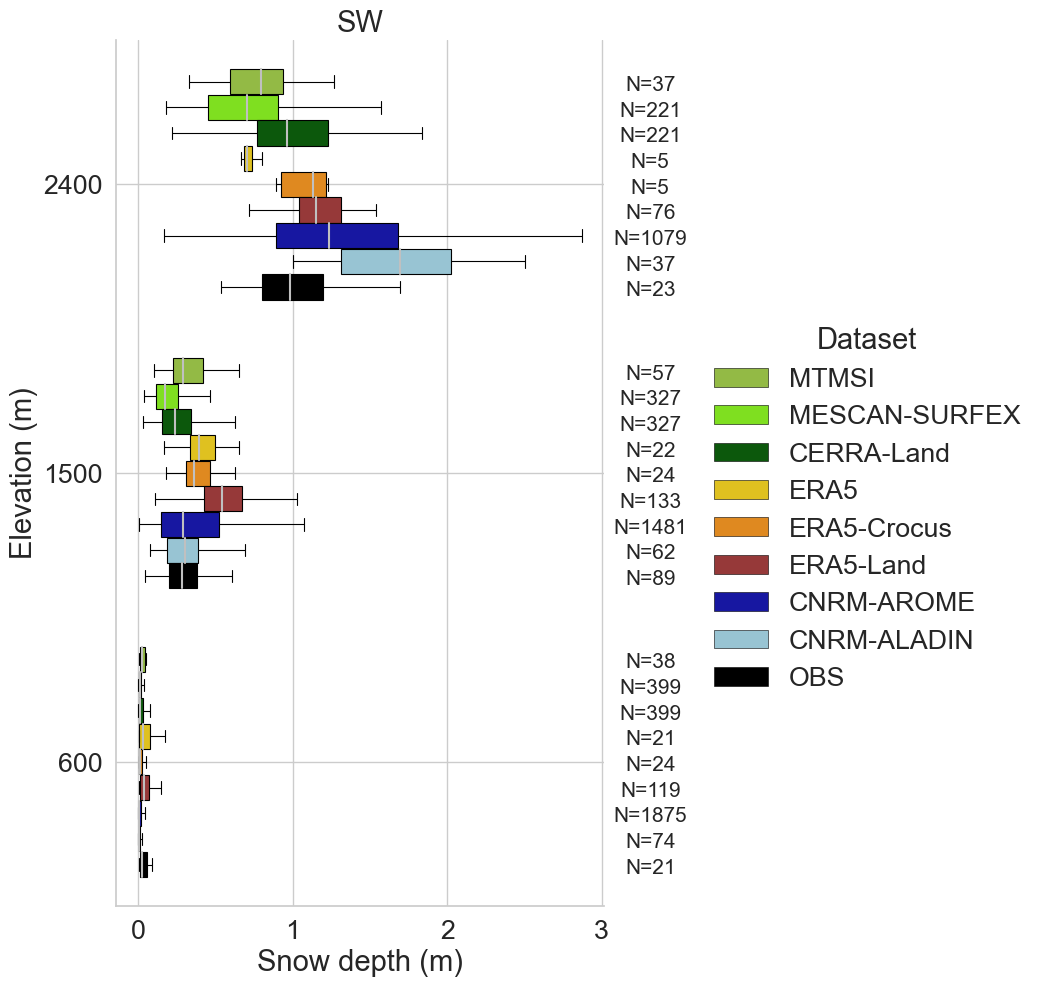

In [11]:
## Boxplot

region = list(np.unique(df['region']))

for i in range(0,len(region)):
    
    df_i = df[df['region'] == region[i]]

    sns.set(font_scale = 1.75)
    sns.set_style("whitegrid")

    g = sns.catplot(data=df_i,x =var,y = 'middle_slices_ZS',hue = 'Dataset' ,orient = 'h',order = reversed(choosen_alt), palette = ls_name_color, kind = 'box',facet_kws={'sharex': True,'legend_out':True},showfliers=False, medianprops=dict(color="silver", linewidth =1.5),n_boot = 10000,linewidth = 0.8, size = 10, aspect = 0.7)
    sns.move_legend(g, "center right", bbox_to_anchor=(1.1, 0.5))

    # Labelled and grid
    for ax in g.axes.flat:
        ax.grid(True, axis='both')
        ax.set_ylabel('Elevation (m)')
        ax.set_xlabel(var_name+' '+unit)


    # Display number of obs per boxplot 
    x_col=var
    y_col='middle_slices_ZS'
    order=list(reversed(choosen_alt))
    hue_col='Dataset'
    hue_order=list(ds_shaped.keys())

    width=0.8
    n_levels = len(df_i[hue_col].unique())
    each_width = width / n_levels
    offsets = np.linspace(0, width - each_width, n_levels)
    offsets -= offsets.mean()-offsets.mean()*(1/8)

    pos = [x+o for x in np.arange(len(order)) for o in offsets]

    counts = df_i.groupby([y_col,hue_col])[x_col].size()
    counts = counts.reindex(pd.MultiIndex.from_product([order,hue_order]))
    medians = df_i.groupby([y_col,hue_col])[x_col].median()
    medians = medians.reindex(pd.MultiIndex.from_product([order,hue_order]))

    for p,n,m in zip(pos,counts,medians):
        if not np.isnan(m):
            ax.annotate('N={:.0f}'.format(n), xy=(ax.get_xlim()[1]+1/10*ax.get_xlim()[1], p), xycoords='data', ha='center', va='bottom', fontsize = 15, annotation_clip=False)
    plt.title(region[i])
    
    plt.savefig(output_path+'Boxplot_region_values_'+var+'_'+period+'_'+region[i]+'.pdf', bbox_inches ='tight')

### Annual cycle of monthly values

In [14]:
## Treat dataset

ls_alt = np.arange(-150,3300,300)
choosen_alt = [600,1500,2400]
month_ordered = ['Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']

difference = False

ds_shaped = {}

for i in range(0,len(list(ls_name.values()))):
    ds_shaped[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]],ls_alt).sel(middle_slices_ZS = choosen_alt)
    ds_shaped[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds_shaped[list(ls_name.keys())[i]],shp_path, 'lat', 'lon', shp['NAME']).drop(['abbrevs', 'names'])
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].mean(dim = ls_spatial_dim[list(ls_name.keys())[i]])

# Groupby by month and average for each month
for i in range(0,len(list(ls_name.values()))):
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].groupby('time.month').mean()
    ds_shaped[list(ls_name.keys())[i]]['month'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]].reindex(month = month_ordered)

# Compute the difference with the reference
if difference == True:
    reference = ds_shaped['OBS'][var]
    if var == 'tas':
        ref_spread = ds_shaped['OBS']['tas_spread']
    
    for i in range(0,len(list(ls_name.values()))):
        if var == 'pr' or var == 'snd':
            ds_shaped[list(ls_name.keys())[i]] = (ds_shaped[list(ls_name.keys())[i]] - reference)/reference*100
        else:
            ds_shaped[list(ls_name.keys())[i]] = ds_shaped[list(ls_name.keys())[i]] - reference
        
# Create the dataframe
df = []
for i in range(0,len(list(ls_name.values()))):
    df_i = ds_shaped[list(ls_name.keys())[i]][var].to_dataframe().reset_index().rename(columns = {'level_0':'month'}).dropna()
    df.append(df_i)
df = pd.concat(df, keys = list(ls_name.keys()))
df = df.reset_index().rename(columns = {'level_0':'Dataset'})



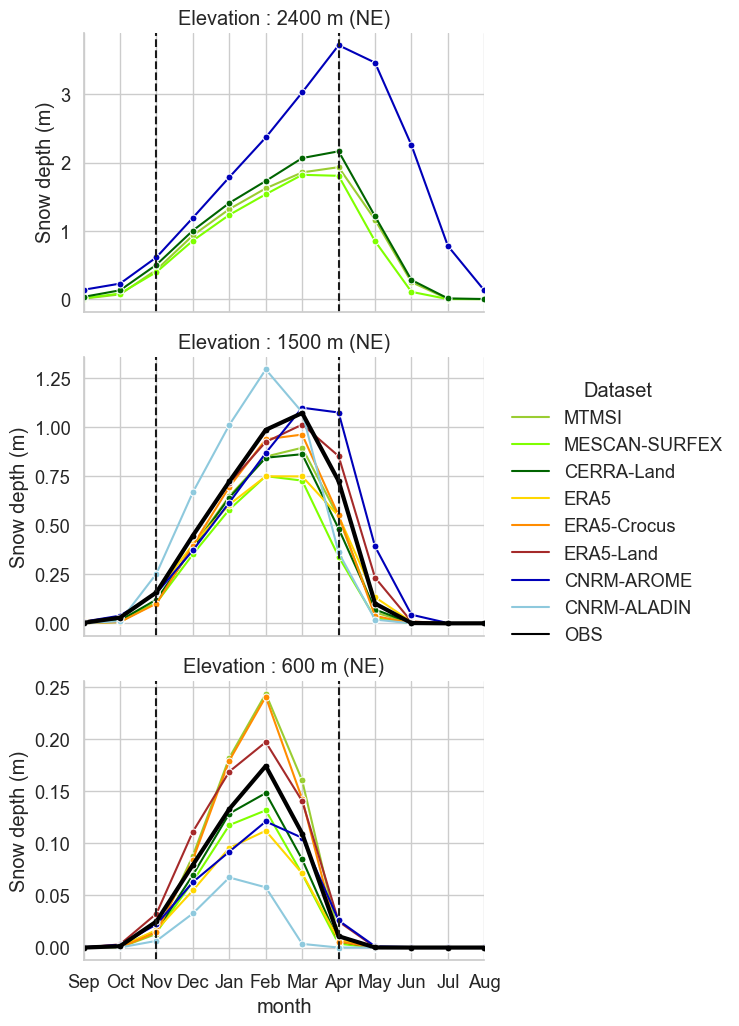

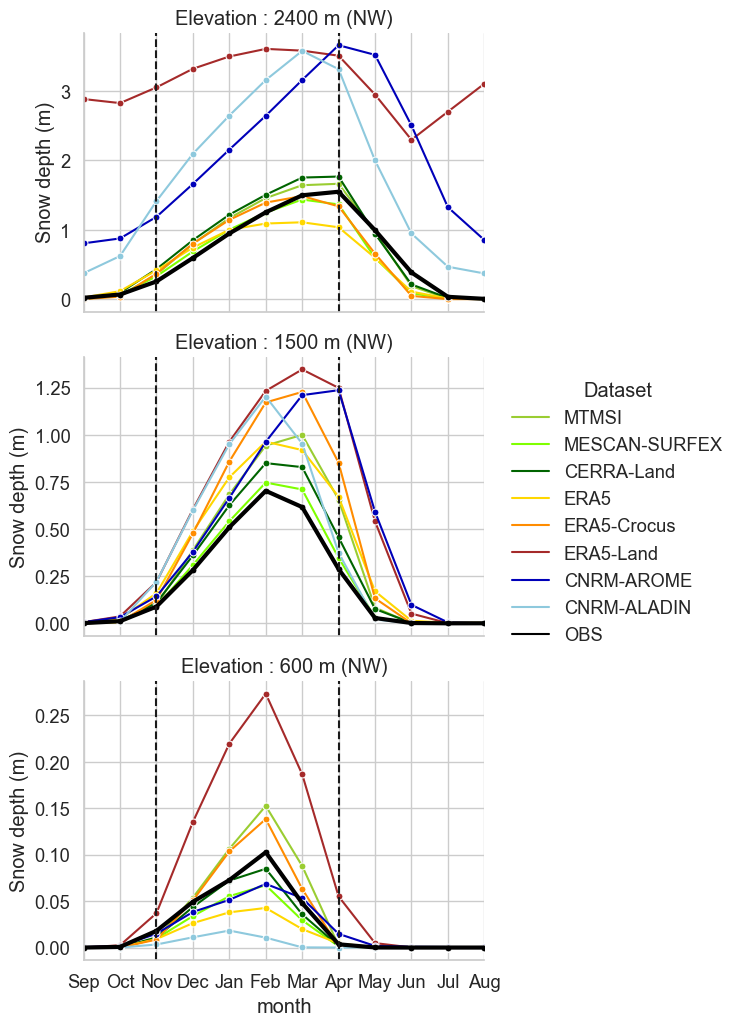

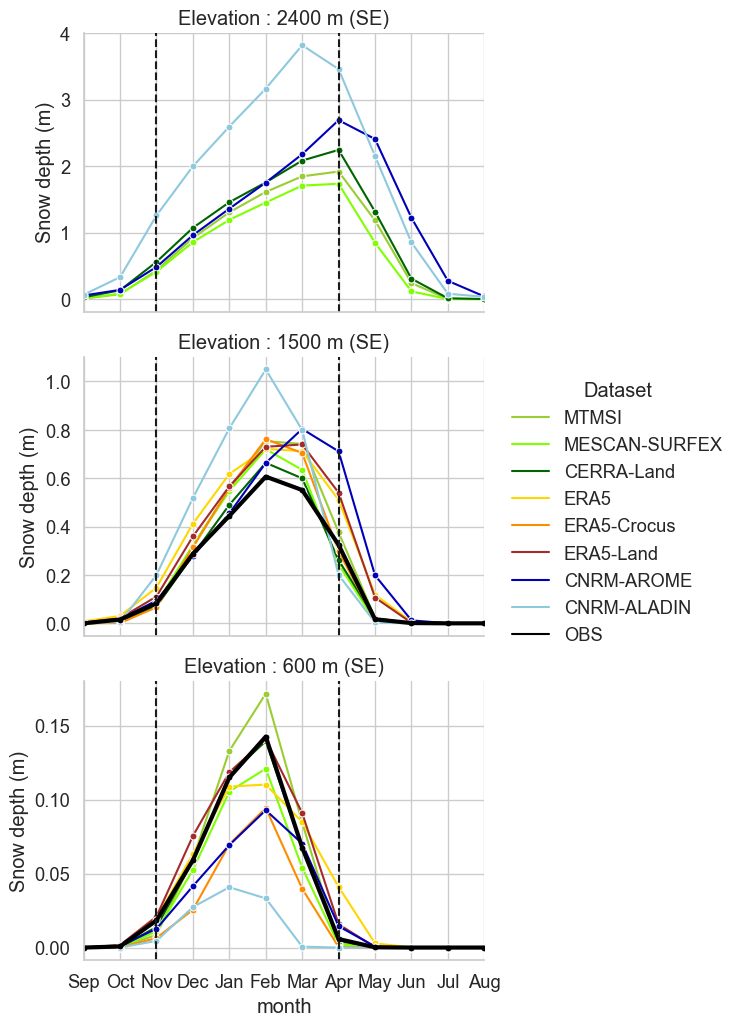

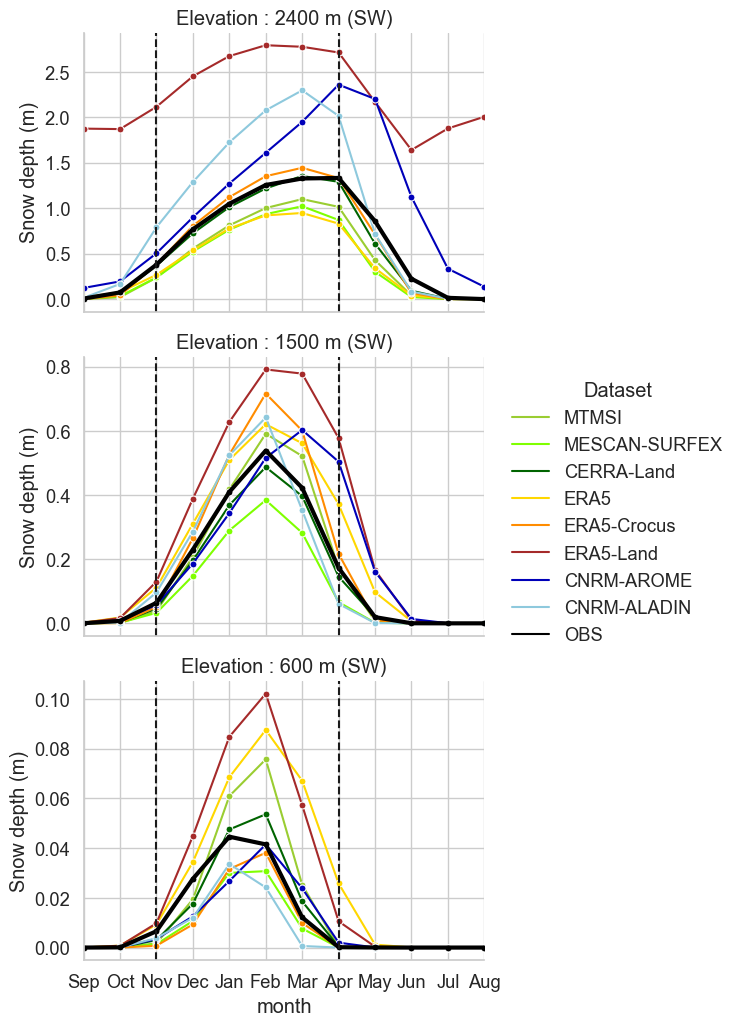

In [16]:
## Plot the annual cycle


region = list(np.unique(df['region']))

for j in range(0,len(region)):
    
    df_i = df[df['region'] == region[j]]

    sns.set(font_scale = 1.2)
    sns.set_style("whitegrid")

    g = sns.relplot(data=df_i, x="month", y=var, hue = 'Dataset', col_order = list(reversed(choosen_alt)),col = 'middle_slices_ZS',col_wrap=1,
                    palette = ls_name_color, kind ='line',facet_kws={'sharey': False, 'sharex': True}, ci = 'sd', marker='o',markersize = 5,lw = 1.5, height=3.5, aspect=6/4)

    # Hghlight the observation line
    axes = g.axes.flatten()
    ref = df_i[df_i['Dataset']=='OBS']

    for i in range(0,len(axes)): 
        ref_i = ref[ref['middle_slices_ZS'] == list(reversed(choosen_alt))[i]]
        # select the data for the region
        sns.lineplot(data=ref_i, x='month', y=var, ax=axes[i], lw=3, color = 'black')

    # Display E-OBS uncertainty fields
    if var == 'tas' and difference == True:
        ref_spread_i = ref_spread.sel(region = region[j])
        for i in range(0,len(list(reversed(choosen_alt)))):
            g.axes.flat[i].fill_between(ref_spread_i.month,-ref_spread_i.sel(middle_slices_ZS = list(reversed(choosen_alt))[i])/2, ref_spread_i.sel(middle_slices_ZS = list(reversed(choosen_alt))[i])/2, color = 'k',alpha = 0.2)

    # Labelled
    sns.despine()
    g.refline(x = 'Nov',color = 'k')
    g.refline(x = 'Apr',color = 'k')
    g.set(xlim=('Sep', 'Aug'))
    g.set_titles("Elevation : {col_name} m " +'('+region[j]+')')

    if difference == True:
        if var == 'tas':
            g.set_ylabels('Δ '+var_name+' (°C)')
        elif var == 'snd':
            g.set_ylabels('Δ '+var_name+' (%)')
        elif var == 'pr':
            g.set_ylabels('Δ '+var_name+' (%)')
    else:
        g.set_ylabels(var_name+' '+unit)

    
    plt.savefig(output_path+'Annual_cycle_'+var+'_'+period+'_'+region[j]+'.pdf', bbox_inches ='tight')

## Running window trends heatmaps

In [17]:
# Defined variable

var = 'scd'
yr_start = 1985
yr_end = 2015

ls_month = [11,12,1,2,3,4]
ls_month_name = ['J','F','M','A','M','J','J','A','S','O','N','D']
period = ''.join(ls_month_name[i-1] for i in ls_month)

ls_alt = np.arange(-150,3300,300)
choosen_alt = [600,1500,2400]

# Path
data_path = '/cnrm/cen/users/NO_SAVE/monteirod/dataset_monthly/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/HISTALP_Alps/'
shp = geopandas.read_file(shp_path)
output_path = '/home/monteirod/tmp/Comparison_UE_Alps/'

# List of dataset names : keys = label names ; values = file extension names
ls_name = {'OBS': 'OBS_insitu_trend',
          'MTMSI': 'MTMSI',
          'MESCAN-SURFEX': 'UERRA',
          'CERRA-Land': "CERRA_Land",
          "ERA5": 'ERA5',
          'ERA5-Crocus': 'ERA5_CROCUS',
          'ERA5-Land': 'ERA5_Land',
          "CNRM-AROME": 'AROME',
          'CNRM-ALADIN': 'ALADIN'}


# List of spatial dimension names : keys = label names ; values = dimension names list
ls_spatial_dim = {'OBS': ['Station_Name'],
                  'MTMSI': ['Number_of_points'], 
                  'MESCAN-SURFEX': ['y', 'x'], 
                  'CERRA-Land': ['y', 'x'],
                  "ERA5": ['lat', 'lon'], 
                  'ERA5-Crocus': ['lat', 'lon'],
                  'ERA5-Land': ['lat', 'lon'],
                  "CNRM-AROME": ['y', 'x'],
                  'CNRM-ALADIN': ['y', 'x']}


# List of color for each datasets
lightness = 0.9
ls_name_color = {'OBS': 'black',
                 'MODIS': 'darkgray',
                 'MTMSI': 'yellowgreen',
                 'MESCAN-SURFEX': 'chartreuse',
                 'CERRA-Land': 'darkgreen',
                 "ERA5": 'gold',
                 'ERA5-Crocus': 'darkorange',
                 'ERA5-Land': 'brown',
                 "CNRM-AROME": u.adjust_lightness('mediumblue',
                                                  lightness),
                 'CNRM-ALADIN': u.adjust_lightness('lightblue',
                                                   lightness)}

# Modification of list depending on the variables investigated
if var == 'snd':
    ls_name['OBS'] = "OBS_insitu_trend"
    ls_spatial_dim['OBS'] = ['Station_Name']
    var_name = 'Snow depth'
    unit = '%'

elif var == 'scd':
    ls_name['OBS'] = "OBS_insitu_trend"
    ls_spatial_dim['OBS'] = ['Station_Name']
    var_name = 'Snow cover duration'
    unit = 'days'
    del ls_name['CNRM-ALADIN']
    
elif var == 'pr':
    ls_name['OBS'] = "LAPrec"
    ls_spatial_dim['OBS'] = ['x', 'y']
    var_name = 'Precipitation'
    unit = '%'

elif var == 'tas':
    ls_name['OBS'] = "E_OBS_HOM"
    ls_spatial_dim['OBS'] = ['lon', 'lat']
    var_name = 'Temperature'
    unit = '°C'


# Load raw pre-treated datasets into a dict without any treatment

ds = {}

for i in range(0, len(list(ls_name.values()))):
    ds[list(ls_name.keys())[i]] = xr.open_dataset(data_path+var+'/'+var+'_' + \
            list(ls_name.values())[i]+'.nc')
    
    if var == 'scd' or var == 'mod' or var == 'sod':
        ds[list(ls_name.keys())[i]]['sod'] = (['time']+ls_spatial_dim[list(ls_name.keys())[i]],[(mdates.date2num(ds[list(ls_name.keys())[i]]['sod'].sel(time = str(j))) - (np.datetime64(str(int(ds[list(ls_name.keys())[i]].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds[list(ls_name.keys())[i]].time.dt.year.values])
        ds[list(ls_name.keys())[i]]['mod'] = (['time']+ls_spatial_dim[list(ls_name.keys())[i]],[(mdates.date2num(ds[list(ls_name.keys())[i]]['mod'].sel(time = str(j))) - (np.datetime64(str(int(ds[list(ls_name.keys())[i]].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds[list(ls_name.keys())[i]].time.dt.year.values])
        ds[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].isel(time = slice(1,-1))[[var]] # Cut the first and last year as they are not complete season
            
    else: # Only select month of interest (winter values in this case)
        ds[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].isel(time=ds[list(ls_name.keys())[i]].time.dt.month.isin(ls_month))
        # Select only complete season if they are overlapping from one year to the next
        ds[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].sel(time = slice(str(int(ds[list(ls_name.keys())[i]].time.dt.year[0]))+'-'+str(ls_month[0]),str(int(ds[list(ls_name.keys())[i]].time.dt.year[-1]))+'-'+str(ls_month[-1])))
    
    ds[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds[list(ls_name.keys())[i]],shp_path, 'lat', 'lon', shp['NAME']).drop(['abbrevs', 'names'])
    ds[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]], ls_alt).sel(middle_slices_ZS = slice(choosen_alt[0],choosen_alt[-1])).mean(dim = 'middle_slices_ZS')

In [18]:
## Treat dataset and compute trends

ls_central_years = np.arange(1955,2017,5)
ls_len_window = np.arange(10,70,10)
method = 'TS'
relative = False

ds_shaped = {}

for i in range(0, len(list(ls_name.values()))):
    print(i)
    # Giving the same weight for each grid points (selected to match the range of choosen alt)
    ds_shaped[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].mean(dim = ls_spatial_dim[list(ls_name.keys())[i]])

# For each datasets
for i in range(0, len(list(ls_name.values()))):
    ds_len = []
    ls_lw_i = []
    
    # Loop over the different window lenght
    for k in range(0, len(ls_len_window)):
        ds_i = []
        ls_cyr_i = []

        # For each central years
        for j in range(0, len(ls_central_years)):

            # Select the year that are matching the running window length around the center year
            i_data = ds_shaped[list(ls_name.keys())[i]].sel(time = slice(str(int(ls_central_years[j]-ls_len_window[k]/2)-1)+'-'+str(ls_month[0]),str(int(ls_central_years[j]+ls_len_window[k]/2))+'-'+str(ls_month[-1])))
            
            if len(np.unique(i_data.time.dt.year)) >= ls_len_window[k] : # Calculate trends if len of time is sufficient
                i_data = u.theilslopes(i_data[var], method = method)
                
                if relative == True: # To transform to relative compared to the mean of the period of the computed trends
                    i_data['slope'] = (i_data['slope']/i_data[var].mean(dim ='time'))*100 
            
                ds_i.append(i_data)
                ls_cyr_i.append(ls_central_years[j])
            
            else : # Pass if the len of the dataset is not enought for this window lenght and central year
                pass
            
        if len(ds_i) > 0 : 
            ds_i = xr.concat(ds_i,dim = 'Central_year')
            ds_i['Central_year'] = ls_cyr_i
            ds_len.append(ds_i)
            ls_lw_i.append(ls_len_window[k])
        
        else: # If dataset complete time length < lenght of the window length
            pass
            
    ds_len = xr.concat(ds_len, dim = 'Window_length')
    ds_len['Window_length'] = ls_lw_i
    
    ds_shaped[list(ls_name.keys())[i]] = ds_len

ds_shaped = xr.concat(list(ds_shaped.values()), dim = 'Dataset')
ds_shaped['Dataset'] = list(ls_name.keys())

0
1
2
3
4
5
6
7


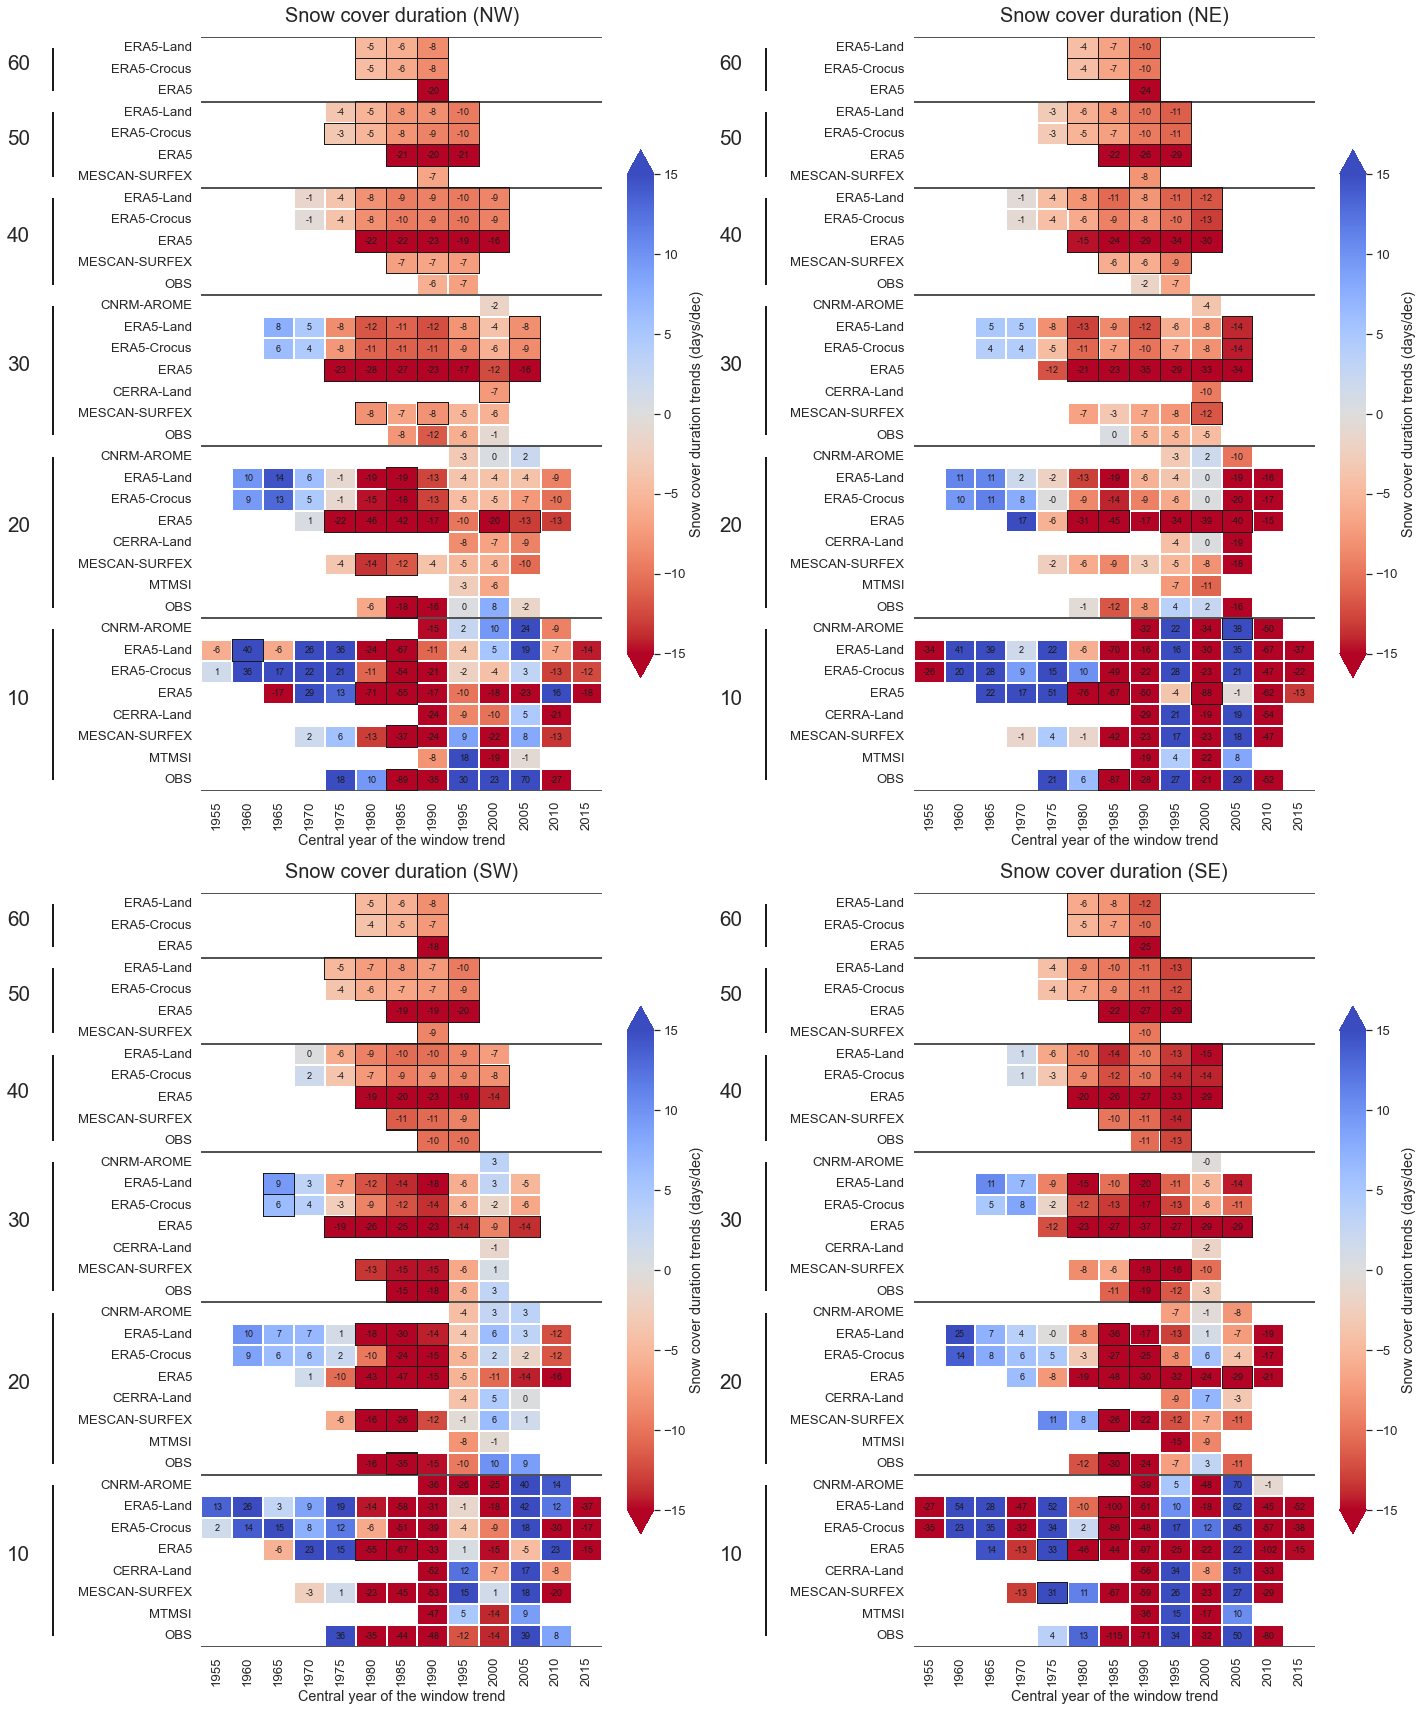

In [19]:
## Create dataframe

region = ['NW','NE','SW','SE']

fig, ax = plt.subplots(2,2,figsize = (10*2,12*2), sharex = False, sharey = False, tight_layout=True)
sns.set(font_scale = 1.2)
sns.set_style('whitegrid')

for j, ax in enumerate(fig.axes):
    
    ds_shaped_i = ds_shaped.sel(region = region[j])

    df = ds_shaped_i['slope'].to_dataframe().pivot_table(index = ['Window_length','Dataset'], columns = 'Central_year')

    # Create dataframe with significative values (loslope and hislope does not cross 0)
    df_sig = ds_shaped_i['slope'].where(ds_shaped_i['loslope']*ds_shaped_i['hislope'] > 0).to_dataframe().pivot_table(index = ['Window_length','Dataset'], columns = 'Central_year')
    df_sig = df_sig.reindex_like(df)

    # Define values for pcolor to highlight signifiative values
    x = np.arange(df_sig.shape[1]+1)
    y = np.arange(df_sig.shape[0]+1)
    values = df_sig.values

    ## Plot the heatmap

    if var == 'snd' or var == 'pr':
        cmap = 'coolwarm_r'
        vmin , vmax = -30,30
        fmt = '.0f'
    elif var == 'tas':
        cmap = 'coolwarm'
        vmin , vmax = -2,2
        fmt = '.1f'
    elif var == 'scd' or var == 'mod' or var == 'sod':
        cmap = 'coolwarm_r'
        vmin , vmax = -15,15
        fmt = '.0f'

    sns.set(font_scale = 1.2)
    sns.set_style('whitegrid')

    sns.heatmap(df, annot=True,robust = True,annot_kws={"size":9, 'color':'k'},fmt =fmt ,vmin = vmin, vmax = vmax,cmap = cmap,cbar_kws={'label': (var_name+' trends '+'('+unit+'/dec)'),"extend":'both',"shrink": 0.7}, ax = ax, linecolor ='w', linewidth = 0.008)
    ax.pcolor(x, y, np.where(values != np.nan, values, np.nan),vmin = vmin, vmax = vmax, cmap=cmap, ec='k', lw=0.02)
    ax.invert_yaxis()


    ax.set_ylabel('')
    ax.set_xlabel('Central year of the window trend')
    ax.set_xticklabels([df.columns[i][1] for i in range(0,len(df.columns))]);
    ax.set_yticklabels([df.index[i][1] for i in range(0,len(df))]);
    ax.set_title(var_name+' ('+region[j]+')', fontsize = 20, pad = 15)
    # ax.grid(True, alpha = 0.2)

    xline = -4.8
    # Get the boundaries of each window length to plot vertical line outside plot
    ls_line = np.insert(np.cumsum([len(ds_shaped_i.slope.sel(Window_length = i).dropna(dim = 'Dataset', how = 'all').Dataset) for i in ds_shaped_i.Window_length]),0,0)

    # Plot horizontal and vertical line, annotate them
    ax.hlines(ls_line,*ax.get_xlim(), color ='k')
    for i in range(0,len(ls_line)-1):
        ax.vlines(x = xline, ymin =ls_line[i]+0.5,ymax =ls_line[i+1]-0.5, clip_on = False, lw =2, color ='k')
        ax.annotate(str(ds_shaped_i.Window_length[i].values), xy =(xline-1.5,ls_line[i+1] - (ls_line[i+1]-ls_line[i])/2),annotation_clip =False, fontsize = 'x-large')

    # fig.suptitle(var_name+' ('+region[j]+')', fontsize = 'xx-large',horizontalalignment ='right', verticalalignment = 'top' )

plt.savefig(output_path+'Heatmap_running_window_trends_'+var+'_'+period+'_'+method+'_region_alps.pdf',bbox_inches = 'tight')


# Table recap of trends (long-term) - Not in the article

In [2]:
# Defined variable

yr_start = 1968
yr_end = 2018

ls_alt = np.arange(-150,3300,300)
choosen_alt = [600,1500,2400]

# Path
data_path = '/cnrm/cen/users/NO_SAVE/monteirod/dataset_monthly/'
shp_path = '/cnrm/cen/users/NO_SAVE/monteirod/Shapefile/HISTALP_Alps/'
shp = geopandas.read_file(shp_path)
output_path = '/home/monteirod/tmp/Comparison_UE_Alps/'

# List of dataset names : keys = label names ; values = file extension names
ls_name = {'Snow depth': 'OBS_insitu_trend',
                 'Snow cover duration' : 'OBS_insitu_trend',
                 'Precipitation':"LAPrec",
                 'Temperature':"E_OBS_HOM"}


# List of spatial dimension names : keys = label names ; values = dimension names list
ls_spatial_dim = {'Snow depth': ['Station_Name'],
                 'Snow cover duration' : ['Station_Name'],
                 'Precipitation':['x','y'],
                 'Temperature':['lon','lat']}

ls_var = {'Snow depth': 'snd',
                 'Snow cover duration' : 'scd',
                 'Precipitation':"pr",
                 'Temperature':"tas"}

# Load raw pre-treated datasets into a dict without any treatment

ds = {}

for i in range(0, len(list(ls_name.values()))):
    ds[list(ls_name.keys())[i]] = xr.open_dataset(data_path+list(ls_var.values())[i]+'/'+list(ls_var.values())[i]+'_' + \
            list(ls_name.values())[i]+'.nc')
    
    if list(ls_var.values())[i] == 'scd':
        ds[list(ls_name.keys())[i]]['sod'] = (['time']+ls_spatial_dim[list(ls_name.keys())[i]],[(mdates.date2num(ds[list(ls_name.keys())[i]]['sod'].sel(time = str(j))) - (np.datetime64(str(int(ds[list(ls_name.keys())[i]].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds[list(ls_name.keys())[i]].time.dt.year.values])
        ds[list(ls_name.keys())[i]]['mod'] = (['time']+ls_spatial_dim[list(ls_name.keys())[i]],[(mdates.date2num(ds[list(ls_name.keys())[i]]['mod'].sel(time = str(j))) - (np.datetime64(str(int(ds[list(ls_name.keys())[i]].sel(time = str(j)).time.dt.year.values))+'-09-01','D') - np.datetime64(mdates.get_epoch(),'D')).astype(int))[0] for j in ds[list(ls_name.keys())[i]].time.dt.year.values])
        ds[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].isel(time = slice(1,-1)) # Cut the first and last year as they are not complete season
        
    ds[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].sel(time = slice(str(yr_start),str(yr_end))) # Cut the first and last year as they are not complete season
    ds[list(ls_name.keys())[i]] = u.applied_mask_from_shp(ds[list(ls_name.keys())[i]],shp_path, 'lat', 'lon', shp['NAME']).drop(['abbrevs', 'names']).mean(dim = 'region')    


In [3]:
## Winter trend values

ls_month = [11,12,1,2,3,4]
ls_month_name = ['J','F','M','A','M','J','J','A','S','O','N','D']
period = ''.join(ls_month_name[i-1] for i in ls_month)

ds_winter = {}

for i in range(0, len(list(ls_var.values()))):
    print(i)
    if list(ls_var.values())[i] == 'scd' or list(ls_var.values())[i] == 'mod' or list(ls_var.values())[i] == 'sod':
        ds_winter[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]]
    else:
        ds_winter[list(ls_name.keys())[i]] = ds[list(ls_name.keys())[i]].isel(time=ds[list(ls_name.keys())[i]].time.dt.month.isin(ls_month))
        # Select only complete season if there are overlapping from one year to the next
        ds_winter[list(ls_name.keys())[i]] = ds_winter[list(ls_name.keys())[i]].sel(time = slice(str(int(ds_winter[list(ls_name.keys())[i]].time.dt.year[0]))+'-'+str(ls_month[0]),str(int(ds_winter[list(ls_name.keys())[i]].time.dt.year[-1]))+'-'+str(ls_month[-1])))

    ds_winter[list(ls_name.keys())[i]] = u.theilslopes(ds_winter[list(ls_name.keys())[i]][list(ls_var.values())[i]], method = 'TS')
    
    if list(ls_var.values())[i] == 'pr' or list(ls_var.values())[i] == 'snd':
        ds_winter[list(ls_name.keys())[i]]['slope'] = (ds_winter[list(ls_name.keys())[i]]['slope']/ds_winter[list(ls_name.keys())[i]][list(ls_var.values())[i]].mean(dim = 'time'))*100
    

0
1
2
3


In [140]:
## Annual trend values

ds_annual = {}

for i in range(0, len(list(ls_var.values()))):
    print(i)
    
    ds_annual[list(ls_name.keys())[i]] = u.theilslopes(ds[list(ls_name.keys())[i]][list(ls_var.values())[i]], method = 'TS')
    
    if list(ls_var.values())[i] == 'pr' or list(ls_var.values())[i] == 'snd':
        ds_annual[list(ls_name.keys())[i]]['slope'] = (ds_annual[list(ls_name.keys())[i]]['slope']/ds_annual[list(ls_name.keys())[i]][list(ls_var.values())[i]].mean(dim = 'time'))*100
    

0
1
2
3


In [147]:
# Merge both annual and winter
for i in range(0, len(list(ls_var.values()))):
    ds[list(ls_name.keys())[i]] = xr.concat([ds_annual[list(ls_name.keys())[i]],ds_winter[list(ls_name.keys())[i]]], dim = 'Period')
    ds[list(ls_name.keys())[i]]['Period'] = ['Annual','Winter']

In [169]:
ds_alt = {}
metrics = ['std' ,'mean','sig','tot']
table = []
for i in range(0, len(list(ls_name.values()))):

    # Calculate for each elevation bands
    ds_alt[list(ls_name.keys())[i]] = u.per_alt(ds[list(ls_name.keys())[i]], ls_alt).sel(middle_slices_ZS = slice(choosen_alt[0],choosen_alt[-1]))    
    ds_alt[list(ls_name.keys())[i]]['std'] = ds_alt[list(ls_name.keys())[i]]['slope'].std(dim = list(ls_spatial_dim.values())[i])
    ds_alt[list(ls_name.keys())[i]]['mean'] = ds_alt[list(ls_name.keys())[i]]['slope'].mean(dim = list(ls_spatial_dim.values())[i])
    
    # Calculate for all elevation band
    ds_all = ds_alt[list(ls_name.keys())[i]].mean(dim = 'middle_slices_ZS').assign_coords({'middle_slices_ZS':'all'})
    ds_all['std'] = ds_all['slope'].std(dim = list(ls_spatial_dim.values())[i])
    ds_all['mean'] = ds_all['slope'].mean(dim = list(ls_spatial_dim.values())[i])

    # Add proportion of sig to non sig trends
    ds_alt[list(ls_name.keys())[i]] = xr.concat([ds_all,ds_alt[list(ls_name.keys())[i]]], dim = 'middle_slices_ZS')
    ds_alt[list(ls_name.keys())[i]]['tot'] = ds_alt[list(ls_name.keys())[i]]['slope'].count(dim = list(ls_spatial_dim.values())[i])
    ds_alt[list(ls_name.keys())[i]]['sig'] = ds_alt[list(ls_name.keys())[i]]['slope'].where(ds_alt[list(ls_name.keys())[i]]['loslope']*ds_alt[list(ls_name.keys())[i]]['hislope'] > 0).count(dim = list(ls_spatial_dim.values())[i])
    
    # Transform into dataframe
    table_i = ds_alt[list(ls_name.keys())[i]][metrics] # Select solely statistic metrics
    table_i = table_i.to_dataframe().reset_index()[['middle_slices_ZS','Period']+metrics].dropna()
    table.append(table_i)

table = pd.concat(table, keys = list(ls_name.keys()))
table['Trend'] = [str(x) for x in unumpy.uarray(table['mean'],table['std'])]
table = table.reset_index().rename(columns = {'level_0':'Variable'})[['Variable','middle_slices_ZS','Period','Trend']+metrics]
table['Sig'] = np.char.add(list((str(x)+'/' for x in table['sig'].values)),list((str(x) for x in table['tot'].values)))

table_sig = table.pivot_table(index = ['middle_slices_ZS','Period'],columns = 'Variable',values = ['Trend','Sig'],aggfunc=lambda x: ' '.join(x)).swaplevel(0,1,axis=1).sort_index(axis=1, ascending = False)
table_sig = table_sig[['Temperature','Precipitation','Snow depth','Snow cover duration']]
table_sig = table_sig.iloc[::-1] # Reversed index

In [234]:
df = table[table['middle_slices_ZS'] == 'all'].pivot_table(index = ['Variable','Period'], values = ['Trend','Sig'],aggfunc=lambda x: ' '.join(x), sort = 'False')
df = df.drop(('Snow cover duration', 'Winter')).drop(('Snow depth', 'Annual'))
df = df.reindex(['Temperature', 'Precipitation','Snow depth','Snow cover duration'], level = 0)
df.index = df.index.set_levels([['Temperature (°C/dec)', 'Precipitation (%/dec)','Snow depth (%/dec)','Snow cover duration (days/dec)'],['Annual','Winter']])

In [237]:
print(df.to_latex())

\begin{tabular}{llll}
\toprule
                               &        &        Trend &        Sig \\
Variable & Period &              &            \\
\midrule
Temperature (°C/dec) & Annual &  0.49+/-0.12 &  1325/2035 \\
                               & Winter &  0.37+/-0.14 &  1132/2035 \\
Precipitation (\%/dec) & Annual &    0.8+/-1.9 &    37/7087 \\
                               & Winter &   -1.2+/-1.6 &     3/7087 \\
Snow depth (\%/dec) & Winter &       -7+/-5 &    390/572 \\
Snow cover duration (days/dec) & Annual &       -8+/-5 &    269/572 \\
\bottomrule
\end{tabular}



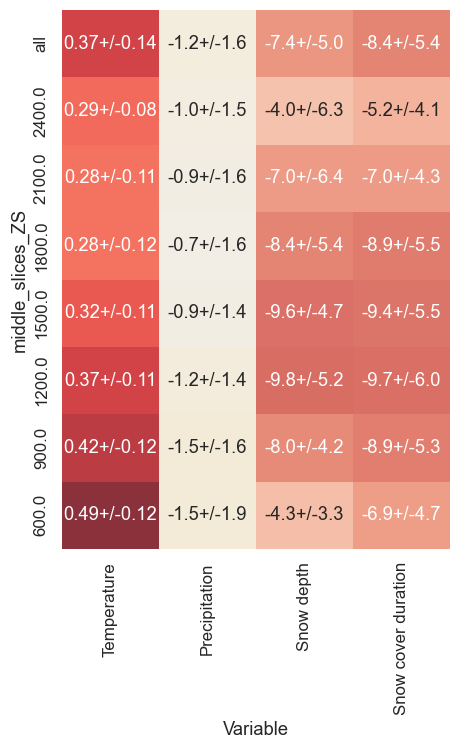

In [28]:
sns.set(font_scale = 1.1)

fig, ax = plt.subplots(figsize = (5,7))

for col in table:
    vmin = table_mean[col].min()
    vmax = table_mean[col].max()
    
    if 'Snow depth' in col:
        cmap = 'coolwarm_r'
        vmin, vmax = -12,12
        fmt = '.1f'
            
    elif 'Snow cover duration' in col:
        cmap = 'coolwarm_r'
        vmin, vmax = -12,12
        fmt = '.1f'
            
    elif 'Temperature' in col:
        cmap = 'Reds'
        vmin, vmax = 0,0.5
        fmt = '.2f'
        
    elif 'Precipitation' in col:
        cmap = 'BrBG'ValueError: Variables  are coordinates in some datasets but not others.
        vmin, vmax = -10,10
        fmt = '.1f'
            
    mask = table_mean.copy()
    for col_m in mask:
        mask[col_m] = col != col_m

    sns.heatmap(data=table_mean,
                annot=table.to_numpy(), annot_kws={'size': 'medium'}, fmt=fmt,
                mask=mask,
                cmap=cmap, vmin=vmin, vmax=vmax, cbar=False, ax=ax, alpha = 0.8)
